In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore, rankdata, kendalltau
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import csv 
from collections import Counter
import datetime
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from lineartree import LinearTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

!pip install holidays


## Relevant information and literature: 

### https://mbcolli.shinyapps.io/SARS2EWSP/
### https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9902279/
### https://nytimes.com/2021/09/13/world/reopening-timeline-nyc-schools.html
### https://www.nytimes.com/2022/01/20/health/nyc-omicron-wasteweater.html

# EDA and Feature Engineering for Pre-Omicron Data

In [2]:

# Create DataFrame
data = {
    'StartDate': ['2020-03-15', '2020-06-26', '2020-09-21', '2020-10-01', '2020-11-19', 
                  '2020-11-29', '2021-02-25', '2021-03-22', '2021-05-24', '2021-06-25', '2021-09-13'],
    'Event': ['Shutdown', 'Summer_Break', 'Pre-K_and_Special_Needs', 'Primary_Middle_and_High', 
              'Shutdown', 'Grade_Schools_Reopen', 'Middle_Schools_Reopen', 
              'High_Schools_Reopen', 'Remote_Learning_Ended', 'Summer_Break', 'Mandatory_In-person_Begins']
}

school_df = pd.DataFrame(data)

# Convert 'StartDate' to datetime
school_df['StartDate'] = pd.to_datetime(school_df['StartDate'])

# Sort DataFrame by 'StartDate'
school_df = school_df.sort_values(by='StartDate')

# Create 'EndDate' as the day before the next event's 'StartDate'
school_df['EndDate'] = school_df['StartDate'].shift(-1) - pd.Timedelta(days=1)

# Replace the last 'EndDate' with October 31, 2021 (just before Omicron began circulating)
school_df.loc[school_df.index[-1], 'EndDate'] = pd.to_datetime('2021-10-31')

# Create a new dataframe with each date and event
date_event_df = pd.DataFrame(columns=['Date', 'Event'])
for i in range(len(school_df)):
    date_range = pd.date_range(start=school_df['StartDate'].iloc[i], end=school_df['EndDate'].iloc[i])
    temp_df = pd.DataFrame({
        'Date': date_range,
        'Event': [school_df['Event'].iloc[i]]*len(date_range)
    })
    date_event_df = pd.concat([date_event_df, temp_df])

# Reset index of the new dataframe
date_event_df.reset_index(drop=True, inplace=True)


# date_event_df.to_csv('school_events.csv', index=False)


In [3]:
school_df = pd.read_csv('data/school_events.csv')

school_df.info

<bound method DataFrame.info of            Date                Event
0    2020-03-15             Shutdown
1    2020-03-16             Shutdown
2    2020-03-17             Shutdown
3    2020-03-18             Shutdown
4    2020-03-19             Shutdown
..          ...                  ...
591  2021-10-27  Mandatory_In-person
592  2021-10-28  Mandatory_In-person
593  2021-10-29  Mandatory_In-person
594  2021-10-30  Mandatory_In-person
595  2021-10-31  Mandatory_In-person

[596 rows x 2 columns]>

In [4]:
ww_df = pd.read_csv('data/SARS-CoV-2_concentrations_measured_in_NYC_Wastewater.csv')

ww_df.head

<bound method NDFrame.head of      Sample Date   Test date       WRRF Name WRRF Abbreviation  \
0     08/31/2020  09/01/2020       26th Ward               26W   
1     08/31/2020  09/01/2020      Bowery Bay                BB   
2     08/31/2020  09/01/2020    Coney Island                CI   
3     08/31/2020  09/01/2020     Hunts Point                HP   
4     08/31/2020  09/01/2020     Jamaica Bay                JA   
...          ...         ...             ...               ...   
3271  04/11/2023  04/12/2023   Port Richmond                PR   
3272  04/11/2023  04/12/2023        Red Hook                RH   
3273  04/11/2023  04/12/2023        Rockaway                RK   
3274  04/11/2023  04/12/2023  Tallman Island                TI   
3275  04/11/2023  04/12/2023    Wards Island                WI   

      Concentration SARS-CoV-2 gene target (N1 Copies/L)   \
0                                                 389.0     
1                                                1204.0

In [5]:
ww_df.dtypes


Sample Date                                                       object
Test date                                                         object
WRRF Name                                                         object
WRRF Abbreviation                                                 object
Concentration SARS-CoV-2 gene target (N1 Copies/L)               float64
Per capita SARS-CoV-2 load (N1 copies per day per population)    float64
Annotation                                                        object
Population Served, estimated                                       int64
dtype: object

In [6]:
ww_df.describe()

,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),"Population Served, estimated"
count,3156.000000,3.157000e+03,3.276000e+03
mean,11412.836499,5.545685e+06,6.146214e+05
std,14586.517564,6.915624e+06,3.454456e+05
min,30.000000,0.000000e+00,1.205390e+05
25%,2964.750000,1.500000e+06,2.587310e+05
50%,7374.000000,3.731525e+06,6.704690e+05
75%,15472.250000,7.540000e+06,9.064420e+05
max,194978.000000,1.072989e+08,1.201485e+06


In [7]:
ww_df.columns

Index(['Sample Date', 'Test date', 'WRRF Name', 'WRRF Abbreviation',
       'Concentration SARS-CoV-2 gene target (N1 Copies/L) ',
       'Per capita SARS-CoV-2 load (N1 copies per day per population)',
       'Annotation', 'Population Served, estimated '],
      dtype='object')

In [8]:
# Let's play around with merging this data before cleaning


# school_df = pd.read_csv('school_events.csv')
# school_df['Date'] = pd.to_datetime(school_df['Date'])



# ww_df = pd.read_csv('SARS-CoV-2_concentrations_measured_in_NYC_Wastewater.csv')
# ww_df = ww_df.rename(columns={'Sample Date': 'Date'})
# ww_df['Date'] = pd.to_datetime(ww_df['Date'])


# # Ensure that both datasets have the same date range
# start_date = max(school_df['Date'].min(), ww_df['Date'].min())
# end_date = min(school_df['Date'].max(), ww_df['Date'].max())

# # New dataframes based on uniform date range
# school_df = school_df[(school_df['Date'] >= start_date) & (school_df['Date'] <= end_date)]
# ww_df = ww_df[(ww_df['Date'] >= start_date) & (ww_df['Date'] <= end_date)]

# # Merge the dataframes  
# merged_df = pd.merge(ww_df, school_df, how='inner', on='Date')

# Save to file
# merged_df.to_csv('wastewater_school.csv', index=False)


In [9]:
merged_df = pd.read_csv('data/wastewater_school.csv')

merged_df.head()

,Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Event
0,2020-08-31,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608,Summer Break_1
1,2020-08-31,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695,Summer Break_1
2,2020-08-31,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342,Summer Break_1
3,2020-08-31,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948,Summer Break_1
4,2020-08-31,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737,Summer Break_1


In [10]:

merged_df.info

<bound method DataFrame.info of             Date   Test date       WRRF Name WRRF Abbreviation  \
0     2020-08-31  09/01/2020       26th Ward               26W   
1     2020-08-31  09/01/2020      Bowery Bay                BB   
2     2020-08-31  09/01/2020    Coney Island                CI   
3     2020-08-31  09/01/2020     Hunts Point                HP   
4     2020-08-31  09/01/2020     Jamaica Bay                JA   
...          ...         ...             ...               ...   
1479  2021-10-26  10/27/2021   Port Richmond                PR   
1480  2021-10-26  10/27/2021        Red Hook                RH   
1481  2021-10-26  10/27/2021        Rockaway                RK   
1482  2021-10-26  10/27/2021  Tallman Island                TI   
1483  2021-10-26  10/27/2021    Wards Island                WI   

      Concentration SARS-CoV-2 gene target (N1 Copies/L)   \
0                                                 389.0     
1                                                1204

In [11]:
# Annotations are mostly empty so we should drop nulls, but not the column! Notes can be very important \n
# We should see what's going on with the Concentration and Per Capita nulls, however.

merged_df.isnull().sum()

Date                                                                0
Test date                                                          15
WRRF Name                                                           0
WRRF Abbreviation                                                   0
Concentration SARS-CoV-2 gene target (N1 Copies/L)                112
Per capita SARS-CoV-2 load (N1 copies per day per population)     112
Annotation                                                       1120
Population Served, estimated                                        0
Event                                                               0
dtype: int64

In [12]:
# Rename dataframe for clarity

merged_df_pre_omi =  merged_df

#  Rename sample date column for clarity, set index
merged_df_pre_omi
merged_df_pre_omi.rename({'Date':'Sample Date'}, axis=1, inplace=True)
merged_df_pre_omi.set_index('Sample Date', inplace=True)

In [13]:
# Stripping the whitespace from column names, then renaming them for convenience:

merged_df_pre_omi.columns = [col.strip() for col in merged_df_pre_omi.columns]

merged_df_pre_omi.rename(columns={'Concentration SARS-CoV-2 gene target (N1 Copies/L)': 'Gene Copies (N1/L)', 
                                  'Per capita SARS-CoV-2 load (N1 copies per day per population)': 'Per Capita Gene Copies', 
                                  'Test date': 'Test Date','Event': 'School Status', 'Population Served, estimated ': 'Est Pop Served'},  inplace=True)


In [14]:
# Let's look at the details of the nulls. Which dates are missing? Do they correspond across both columns (not including
# annotations)?

# Get series of missing conentration values

conc_null = merged_df_pre_omi['Gene Copies (N1/L)'].isnull()

merged_df_pre_omi.head()

,Test Date,WRRF Name,WRRF Abbreviation,Gene Copies (N1/L),Per Capita Gene Copies,Annotation,"Population Served, estimated",School Status
Sample Date,,,,,,,,
2020-08-31,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608,Summer Break_1
2020-08-31,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695,Summer Break_1
2020-08-31,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342,Summer Break_1
2020-08-31,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948,Summer Break_1
2020-08-31,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737,Summer Break_1


In [15]:
# Get series of missing per capita values

per_cap_null = merged_df_pre_omi['Per Capita Gene Copies'].isnull()

# Get just the missing dates from these

missing_dates_conc = conc_null.where(conc_null==True).index.tolist()
missing_dates_pc = per_cap_null.where(per_cap_null==True).index.tolist()

# Check to see that the dates are the same

set(missing_dates_conc) == set(missing_dates_pc)

True

In [16]:
# Get just the counts (this makes a dictionary counter):

date_counts_conc = Counter(missing_dates_conc)
date_counts_pc = Counter(missing_dates_pc)

# Check to see if the tally of the missing days the same

date_counts_conc == date_counts_pc 

True

In [17]:
# OK, perfect, we've established that the missing dates for the concentrations and the per capita info are the same.

Text(0.5, 0, 'Date')

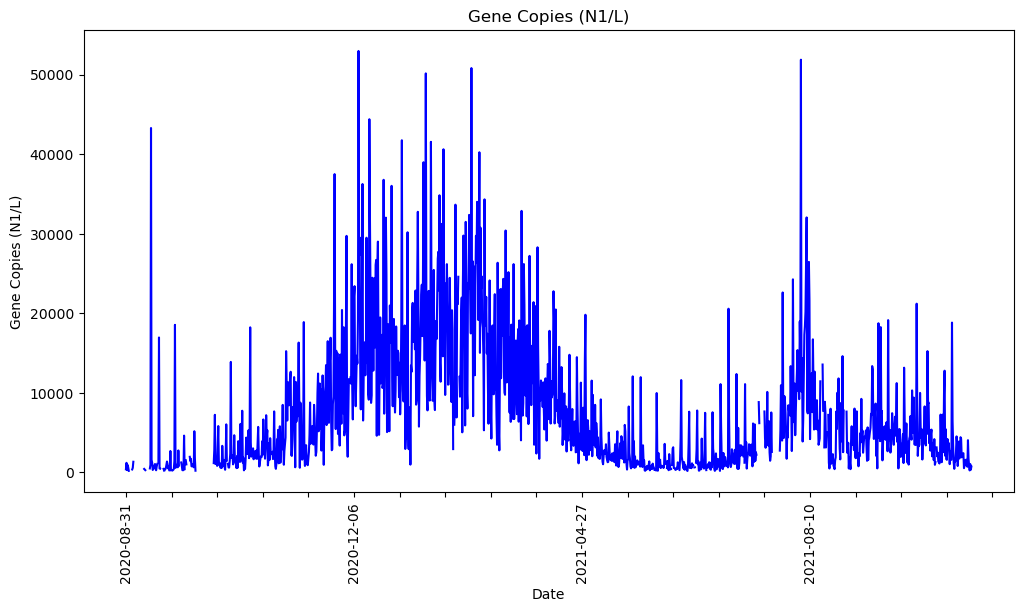

In [18]:
# Visualizing our data; first let's just look at wastewater levels in the pre-Omicron period
 
# Custom ticker, since we haven't augmented the dates 

# assuming df is your DataFrame and 'Gene Copies (N1/L)' is one of your columns
df = pd.DataFrame(merged_df_pre_omi['Gene Copies (N1/L)'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
df['Gene Copies (N1/L)'].plot(ax=ax, color='blue')

ax.xaxis.set_major_locator(ticker.MaxNLocator(25))  # Display a maximum of 10 x-ticks

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Set labels
plt.title('Gene Copies (N1/L)')
plt.ylabel('Gene Copies (N1/L)')
plt.xlabel('Date')



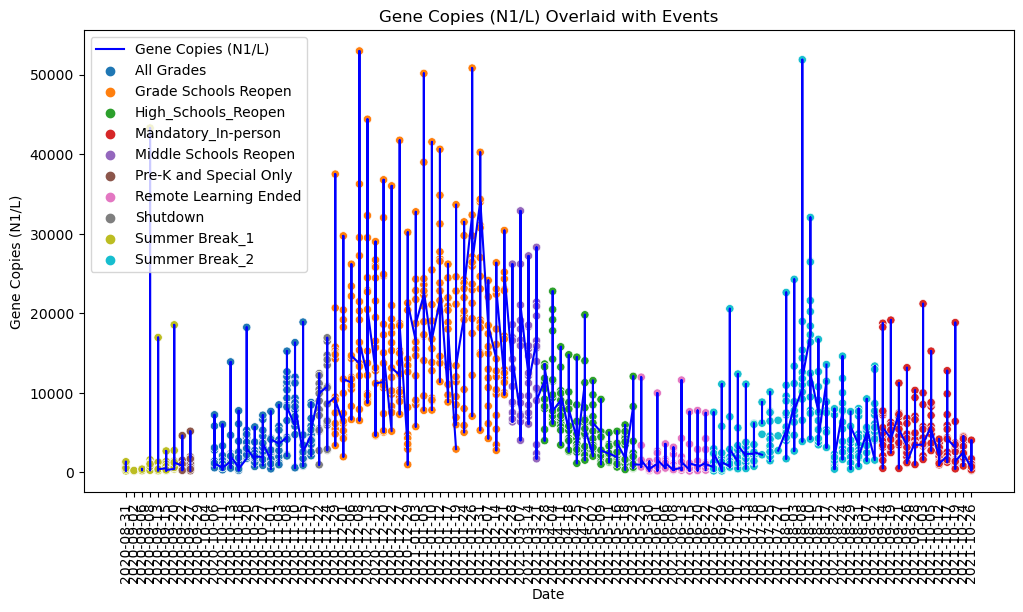

In [19]:
# Now let's look at this with the school events of 2020-2021

merged_df_pre_omi['School Status'] = merged_df_pre_omi['School Status'].astype('category')

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the wastewater data
plt.plot(merged_df_pre_omi.index, merged_df_pre_omi['Gene Copies (N1/L)'], color='blue', label='Gene Copies (N1/L)')

# Add scatterplot of events, color-coded
sns.scatterplot(x=merged_df_pre_omi.index, y=merged_df_pre_omi['Gene Copies (N1/L)'], hue=merged_df_pre_omi['School Status'])

# Rotate x-ticks for better visibility
plt.xticks(rotation=90)

# Set labels
plt.title('Gene Copies (N1/L) Overlaid with Events')
plt.xlabel('Date')
plt.ylabel('Gene Copies (N1/L)')

# Display the legend
plt.legend()

plt.show()


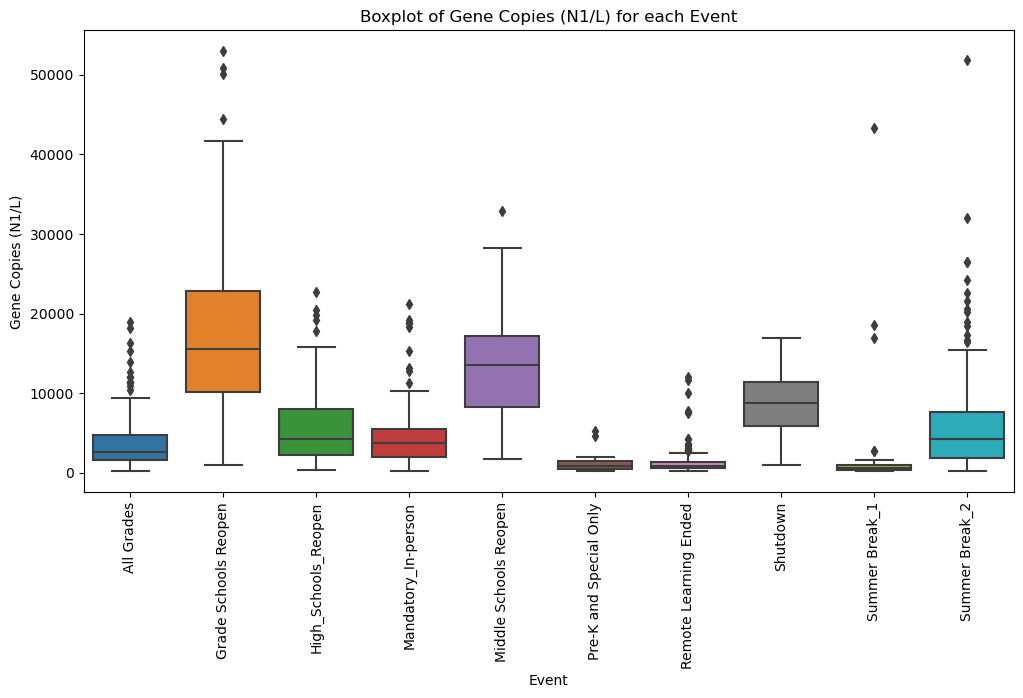

In [20]:
# Clearly there is a relation!!!


fig, ax = plt.subplots(figsize=(12, 6))


sns.boxplot(x="School Status", y="Gene Copies (N1/L)", data=merged_df_pre_omi, ax=ax)

# Set labels
ax.set_title('Boxplot of Gene Copies (N1/L) for each Event')
ax.set_xlabel('Event')
ax.set_ylabel('Gene Copies (N1/L)')

# Rotate x-ticks for better visibility
plt.xticks(rotation=90)

plt.show()

In [21]:
# Want to investigate wastewater facilities by how many school-aged children they serve (as residents - 90% of
# school-children attend school in their district, which is correlated with zip code. Source: https://wherewelive.cityofnewyork.us/explore-data/access-to-opportunity/education/



In [22]:
# Making a csv file with all the zip codes. Will have to manually input school-age populations, it seems, and 
# then group by the facility. Note: I cannot find any source that delineates wastewater by zipcode, but there are 
# generalized maps from reputable sources. 

# nyc_zip_codes = [
#     10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010,
#     10011, 10012, 10013, 10014, 10016, 10017, 10018, 10019, 10020,
#     10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029,
#     10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038,
#     10039, 10040, 10044, 10065, 10069, 10075, 10103, 10110, 10111,
#     10112, 10115, 10119, 10128, 10152, 10153, 10154, 10162, 10165,
#     10167, 10168, 10169, 10170, 10171, 10172, 10173, 10177, 10199,
#     10270, 10271, 10278, 10279, 10280, 10282, 10301, 10302, 10303,
#     10304, 10305, 10306, 10307, 10308, 10309, 10310, 10312, 10314,
#     10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459,
#     10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468,
#     10469, 10470, 10471, 10472, 10473, 10474, 10475, 11004, 11005,
#     11101, 11102, 11103, 11104, 11105, 11106, 11201, 11203, 11204,
#     11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213,
#     11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222,
#     11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232,
#     11233, 11234, 11235, 11236, 11237, 11238, 11239, 11354, 11355,
#     11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364,
#     11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373,
#     11374, 11375, 11377, 11378, 11379, 11385, 11411, 11412, 11413,
#     11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422,
#     11423, 11426, 11427, 11428, 11429, 11430, 11432, 11433, 11434,
#     11435, 11436, 11691, 11692, 11693, 11694, 11697
# ]

# # Create a DataFrame with the ZIP codes as rows
# kids_zipcodes = pd.DataFrame(nyc_zip_codes, columns=['ZIP'])

# # Add six blank columns
# for i in range(1, 7):
#     kids_zipcodes[f'Column{i}'] = ''

# # Save to CSV
# kids_zipcodes.to_csv('nyc_zip_codes.csv', index=False)


In [23]:
### Created zipcode and school-aged population document from data entered in a spreadsheet 
### and made a new csv doc out of it. 

## CAVEAT: These population estimates are taken from US Census Data for 2021.  


In [24]:

data = """
ZIP	5-9	10-14	 15-19
10001	1012	829	879
10002	3061	3337	2555
10003	924	865	7320
10004	147	176	119
10005	235	198	81
10006	133	90	415
10007	448	242	216
10009	1242	2235	2235
10010	1631	784	1965
10011	1153	1218	2243
10012	199	506	637
10013	1193	1340	1031
10014	456	649	534
10016	1379	1379	1105
10017	226	310	93
10018	141	120	256
10019	898	509	870
10020	0	0	0
10021	1517	2024	1928
10022	746	1028	686
10023	3036	1908	2715
10024	3096	3367	1674
10025	3991	3633	4692
10026	2079	2115	1699
10027	3182	3125	3125
10028	2327	1747	1083
10029	3922	3588	4762
10030	1593	1768	1006
10031	2910	2767	2626
10032	2103	1938	2679
10033	2604	2913	2415
10034	1841	2409	1802
10035	2132	1929	1890
10036	498	658	549
10037	994	1065	473
10038	538	1356	1455
10039	1667	1714	1768
10040	1667	1714	1768
10044	472	402	274
10065	1270	1072	674
10069	261	635	82
10075	872	616	1095
10103	0	0	0
10110	0	0	0
10111	0	0	0
10112	0	0	0
10115	0	0	0
10119	0	0	0
10128	1936	1928	2281
10152	0	0	0
10153	0	0	0
10154	0	0	0
10162	0	82	61
10165	0	0	0
10167	0	0	0
10168	0	0	0
10169	0	0	0
10170	0	0	0
10171	0	0	0
10172	0	0	0
10173	0	0	0
10177	0	0	0
10199	0	0	0
10270	0	0	0
10271	0	0	0
10278	0	0	0
10279	0	0	0
10280	286	218	256
10282	574	535	269
10301	1881	2020	2442
10302	1170	1295	1180
10303	1861	2502	2148
10304	2628	2928	2913
10305	2771	2439	2606
10306	2546	3011	4018
10307	704	1000	1324
10308	1320	1904	1884
10309	2029	2626	2028
10310	1550	1585	1751
10312	4021	4490	3653
10314	4863	5591	6127
10451	3499	3227	3379
10452	6280	7099	6229
10453	6325	6011	5621
10454	3142	3452	2323
10455	3728	3524	3564
10456	6352	7408	6949
10457	6498	7157	5060
10458	6766	6246	7831
10459	3588	3934	3987
10460	4037	4581	4262
10461	NaN	NaN	NaN
10462	4928	5306	4147
10463	4435	4238	4593
10464	400	127	87
10465	2061	2989	3558
10466	3980	5479	5243
10467	7567	7573	6254
10468	7336	5392	5943
10469	3478	5115	5243
10470	560	478	650
10471	783	1225	2067
10472	4879	4833	4569
10473	3626	4003	3978
10474	1178	863	695
10475	2242	1682	1761
11004	726	923	709
11005	0	0	0
11101	1556	1348	1145
11102	881	858	1114
11103	1104	1120	1344
11104	1216	1182	1064
11105	1561	1382	1081
11106	1540	1795	1289
11201	3384	2828	2768
11203	4055	4418	4278
11204	6533	6766	5140
11205	4237	3899	4245
11206	6649	7546	6397
11207	7007	6579	5343
11208	7943	8362	7298
11209	4002	3580	3766
11210	4456	4759	4378
11211	3450	3293	2942
11212	4450	5399	4026
11213	3854	4635	4126
11214	5365	5862	5095
11215	4287	4303	2594
11216	2618	2179	1643
11217	1610	1675	1284
11218	5628	6174	4630
11219	9883	8960	7157
11220	7334	6422	4993
11221	4655	4832	4242
11222	1504	880	727
11223	6293	5009	5175
11224	2515	2925	2752
11225	2733	3248	2834
11226	5160	5254	5353
11228	2264	2269	2343
11229	5474	5996	4660
11230	5236	5474	5996
11231	3750	2988	2165
11232	1875	1607	1271
11233	5591	4421	4516
11234	5468	5131	6702
11235	3757	4227	3530
11236	6381	6175	6106
11237	2016	2912	2490
11238	2200	2354	1287
11239	786	996	1151
11354	1923	2297	2049
11355	3509	3311	2904
11356	1499	1846	1864
11357	2165	3188	2191
11358	1839	2277	1705
11359	0	0	0
11360	557	799	937
11361	1436	1804	1089
11362	984	725	766
11363	450	354	313
11364	2140	2441	2123
11365	1964	2973	2734
11366	613	788	622
11367	2685	2269	2636
11368	7795	8560	7570
11369	1329	2025	1823
11370	1171	1273	1651
11371	0	0	0
11372	3860	3552	2547
11373	5785	6709	5933
11374	2392	2006	1587
11375	4181	3446	2391
11377	3780	4188	3365
11378	2004	2819	2820
11379	2123	2777	1677
11385	5392	7136	5878
11411	725	1425	993
11412	1912	2356	2519
11413	2456	2972	2757
11414	1669	1727	1190
11415	1149	933	622
11416	1590	1691	1866
11417	2217	2299	1883
11418	2089	2417	2270
11419	1985	2640	2689
11420	2441	2655	3195
11421	1985	2640	2689
11422	1665	2202	2206
11423	1576	1719	1677
11426	1009	1173	860
11427	1114	1370	1137
11428	965	1130	1075
11429	1196	1342	1812
11430	0	14	0
11432	3631	3917	3473
11433	2421	3194	3007
11434	4296	4277	4151
11435	3738	3212	2977
11436	1405	1301	1318
11691	6282	6359	4749
11692	1740	2367	1256
11693	992	883	935
11694	1177	1653	1035
11697	246	164	148
""".strip()  

data = [row.split('\t') for row in data.split('\n')]

with open('data/zipcodes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)


In [25]:
zip_df = pd.read_csv('data/zipcodes.csv')
zip_df.head()


,ZIP,5-9,10-14,15-19
0,10001,1012.0,829.0,879.0
1,10002,3061.0,3337.0,2555.0
2,10003,924.0,865.0,7320.0
3,10004,147.0,176.0,119.0
4,10005,235.0,198.0,81.0


In [26]:
zip_df.rename(columns={'ZIP': 'Zipcode'}, inplace=True)


In [27]:
zip_df.head()

,Zipcode,5-9,10-14,15-19
0,10001,1012.0,829.0,879.0
1,10002,3061.0,3337.0,2555.0
2,10003,924.0,865.0,7320.0
3,10004,147.0,176.0,119.0
4,10005,235.0,198.0,81.0


In [28]:
# Very rough assignment of zipcodes to wastewater facilities: these do NOT line up evenly by zip code or even
#borough. This data was estimated by eye comparison of maps. We left out all the zip codes that are assigned to
# individual buildings in Manhattan - these are corporate buildings and have no residents.
ww_zips = {
  'Port Richmond': ['10304', '10301', '10314', '10310', '10302', '10303'],
  'Oakwood Beach': ['10305', '10306', '10318', '10312', '10309', '10307', '10308'],
  'Wards Island': ['10075','10021', '10028', '10065', '10128', '10029', '10035', '10037', '10030', '10039', '10032', '10033', '10040', '10454', '10451', '10452', '10453', '10468', '10463', '10471', '10458', '10457', '10456', '10455', '11370'],
  'Bowery Bay': ['11415','11378','11372','11103', '11104', '11102', '11105', '11106', '11371', '11369', '11370', '11101', '11109', '11377', '11373', '11374', '11375', '11368', '10044', '10370'],
  'North River': ['10034', '10069', '10031', '10027', '10026', '10025', '10024', '10023', '10019', '10036', '10018', '10001', '10011', '10014'],
  'Newtown Creek': ['11379','11222','11221','11206', '10280', '10282','10012', '10013', '10007', '10006', '10004', '10038', '10002', '10009', '10010', '10016', '10017', '10022', '10005', '10003', '10211', '11211', '11266', '11237', '11385', '11233', '11225', '11205', '11238', '11216', '11213'],
  'Hunts Point': ['10461', '10473', '10470', '10466', '10464', '10465', '10461', '10475', '10469', '10462', '10463', '10472', '10474', '10459', '10460', '10467', '11370'],
  'Coney Island': ['11236','11224', '11235', '11230', '11226', '11210', '11229', '11234'],
  '26th Ward': ['11239', '11208', '11207', '11212', '11203'],
  'Red Hook': ['11251', '11201', '11231', '11215', '11217'],
  'Owls Head': ['11232', '11220', '11209', '11214', '11223', '11204', '11218', '11219', '11228'],
  'Tallman Island': ['11365','11364','11356', '11357', '11359', '11360', '11361', '11363', '11362', '11004', '11005', '11427', '11366', '11367', '11355', '11354', '11358'],
  'Jamaica Bay': ['11435','11428', '11421', '11418','11417', '11416','11414','11430', '11422', '11413', '11434', '11436', '11420', '11419', '11437', '11432', '11423', '11426', '11429', '11411', '11412', '11433'],
  'Rockaway': ['11697', '11694', '11593', '11692', '11691', '11693']
}

    

    


In [29]:
csv_data = []
for facility, zipcodes in ww_zips.items():
    for zipcode in zipcodes:
        csv_data.append([facility, zipcode])

csv_file_path = "data/ww_zips.csv"

with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Location", "Zipcode"]) 
    writer.writerows(csv_data)  
csv_file_path

'data/ww_zips.csv'

In [30]:
ww_zips_df = pd.read_csv('data/ww_zips.csv')
ww_zips_df.head()

,Location,Zipcode
0,Port Richmond,10304
1,Port Richmond,10301
2,Port Richmond,10314
3,Port Richmond,10310
4,Port Richmond,10302


In [31]:


zip_df.rename({'ZIP': 'Zipcode'}, axis=1, inplace=True)

print(ww_zips_df.info())
print(zip_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Location  192 non-null    object
 1   Zipcode   192 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zipcode  205 non-null    int64  
 1   5-9      204 non-null    float64
 2   10-14    204 non-null    float64
 3    15-19   204 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 6.5 KB
None


In [32]:
# NOw we have our merged dataframe with all our basic info
merged_df = pd.merge(zip_df, ww_zips_df, on='Zipcode', how='left')

merged_df.head()

,Zipcode,5-9,10-14,15-19,Location
0,10001,1012.0,829.0,879.0,North River
1,10002,3061.0,3337.0,2555.0,Newtown Creek
2,10003,924.0,865.0,7320.0,Newtown Creek
3,10004,147.0,176.0,119.0,Newtown Creek
4,10005,235.0,198.0,81.0,Newtown Creek


In [33]:
facilities_1 = merged_df_pre_omi['WRRF Name'].value_counts()

facilities_2 = merged_df['Location'].value_counts()

sorted(facilities_1.index) == sorted(facilities_2.index)

True

In [34]:

# Ok, so our zipcodes are finally good, and our location names line up, so we can actually integrate this hard-won data!

In [35]:
merged_df.rename(columns={'Location':'WRRF Name'}, inplace=True)

merged_df.head()

,Zipcode,5-9,10-14,15-19,WRRF Name
0,10001,1012.0,829.0,879.0,North River
1,10002,3061.0,3337.0,2555.0,Newtown Creek
2,10003,924.0,865.0,7320.0,Newtown Creek
3,10004,147.0,176.0,119.0,Newtown Creek
4,10005,235.0,198.0,81.0,Newtown Creek


In [36]:
merged_df.isnull().sum()

Zipcode       0
5-9           2
10-14         2
 15-19        2
WRRF Name    25
dtype: int64

In [37]:
no_match = merged_df[merged_df['WRRF Name'].isnull()]['Zipcode'].unique().tolist()

print(no_match)

# As expected, these are all zipcodes that belong to individual buildings and which I did not assign to a wastewater
# facility. There are all (or mostly) office buildings and are not relevant for the pre-omicron period. 

[10020, 10103, 10110, 10111, 10112, 10115, 10119, 10152, 10153, 10154, 10162, 10165, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10177, 10199, 10270, 10271, 10278, 10279]


In [38]:
# We're just going to go ahead and drop all these nulls, since they're not relevant here.

merged_df.dropna(inplace=True)

merged_df.isnull().sum()

Zipcode      0
5-9          0
10-14        0
 15-19       0
WRRF Name    0
dtype: int64

In [39]:
merged_df['Total Population'] = merged_df.iloc[:, 1:].sum(axis=1)

merged_df.head()

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_56282/780496910.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_df['Total Population'] = merged_df.iloc[:, 1:].sum(axis=1)


,Zipcode,5-9,10-14,15-19,WRRF Name,Total Population
0,10001,1012.0,829.0,879.0,North River,2720.0
1,10002,3061.0,3337.0,2555.0,Newtown Creek,8953.0
2,10003,924.0,865.0,7320.0,Newtown Creek,9109.0
3,10004,147.0,176.0,119.0,Newtown Creek,442.0
4,10005,235.0,198.0,81.0,Newtown Creek,514.0


In [40]:
merged_df['Total WRRF Population'] = merged_df.groupby('WRRF Name')['Total Population'].transform('sum')

merged_df.head()

,Zipcode,5-9,10-14,15-19,WRRF Name,Total Population,Total WRRF Population
0,10001,1012.0,829.0,879.0,North River,2720.0,72242.0
1,10002,3061.0,3337.0,2555.0,Newtown Creek,8953.0,188137.0
2,10003,924.0,865.0,7320.0,Newtown Creek,9109.0,188137.0
3,10004,147.0,176.0,119.0,Newtown Creek,442.0,188137.0
4,10005,235.0,198.0,81.0,Newtown Creek,514.0,188137.0


In [41]:
# Looking good!

test = merged_df['Total WRRF Population'].value_counts()

len(test.index)

print(test.index)

Float64Index([188137.0, 240219.0, 131881.0, 122994.0,  74748.0, 151282.0,
               72242.0, 135396.0, 117865.0,  46435.0,  44374.0,  72091.0,
               29986.0,  33636.0],
             dtype='float64')


In [42]:
# OK, so now we have the facilities and their total school-aged populations!

wrrf_population = merged_df.groupby('WRRF Name')['Total WRRF Population'].first()

print(wrrf_population)

WRRF Name
26th Ward          72091.0
Bowery Bay        122994.0
Coney Island      117865.0
Hunts Point       151282.0
Jamaica Bay       131881.0
Newtown Creek     188137.0
North River        72242.0
Oakwood Beach      44374.0
Owls Head         135396.0
Port Richmond      46435.0
Red Hook           33636.0
Rockaway           29986.0
Tallman Island     74748.0
Wards Island      240219.0
Name: Total WRRF Population, dtype: float64


In [43]:
merged_df['Zipcode'].value_counts().head(20)

# Will have to clean this up. 11370 is Rikers and is split between 3 facilities. 10463 needs fixing



11370    3
10463    2
10001    1
11237    1
11229    1
11230    1
11231    1
11232    1
11233    1
11234    1
11235    1
11236    1
11238    1
11239    1
11354    1
11355    1
11356    1
11357    1
11358    1
11359    1
Name: Zipcode, dtype: int64

In [44]:
# Testing out this mapping

merged_df_pre_omi['Total WRRF Population'] = merged_df_pre_omi['WRRF Name'].map(merged_df.groupby('WRRF Name')['Total WRRF Population'].first())

print(merged_df_pre_omi.shape)

merged_df_pre_omi.head()

(1484, 9)


,Test Date,WRRF Name,WRRF Abbreviation,Gene Copies (N1/L),Per Capita Gene Copies,Annotation,"Population Served, estimated",School Status,Total WRRF Population
Sample Date,,,,,,,,,
2020-08-31,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608,Summer Break_1,72091.0
2020-08-31,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695,Summer Break_1,122994.0
2020-08-31,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342,Summer Break_1,117865.0
2020-08-31,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948,Summer Break_1,151282.0
2020-08-31,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737,Summer Break_1,131881.0


In [45]:
# Yay! Finally, a new dataframe with the corresponding school-age population for each wastewater site! 

In [46]:
merged_df_pre_omi.rename(columns={'Total WRRF Population': 'School-Aged Population'}, inplace=True)

merged_df_pre_omi.head()

,Test Date,WRRF Name,WRRF Abbreviation,Gene Copies (N1/L),Per Capita Gene Copies,Annotation,"Population Served, estimated",School Status,School-Aged Population
Sample Date,,,,,,,,,
2020-08-31,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608,Summer Break_1,72091.0
2020-08-31,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695,Summer Break_1,122994.0
2020-08-31,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342,Summer Break_1,117865.0
2020-08-31,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948,Summer Break_1,151282.0
2020-08-31,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737,Summer Break_1,131881.0


In [47]:
merged_df_pre_omi.isnull().sum() # nulls looking good! We didn't change anything!

Test Date                         15
WRRF Name                          0
WRRF Abbreviation                  0
Gene Copies (N1/L)               112
Per Capita Gene Copies           112
Annotation                      1120
Population Served, estimated       0
School Status                      0
School-Aged Population             0
dtype: int64

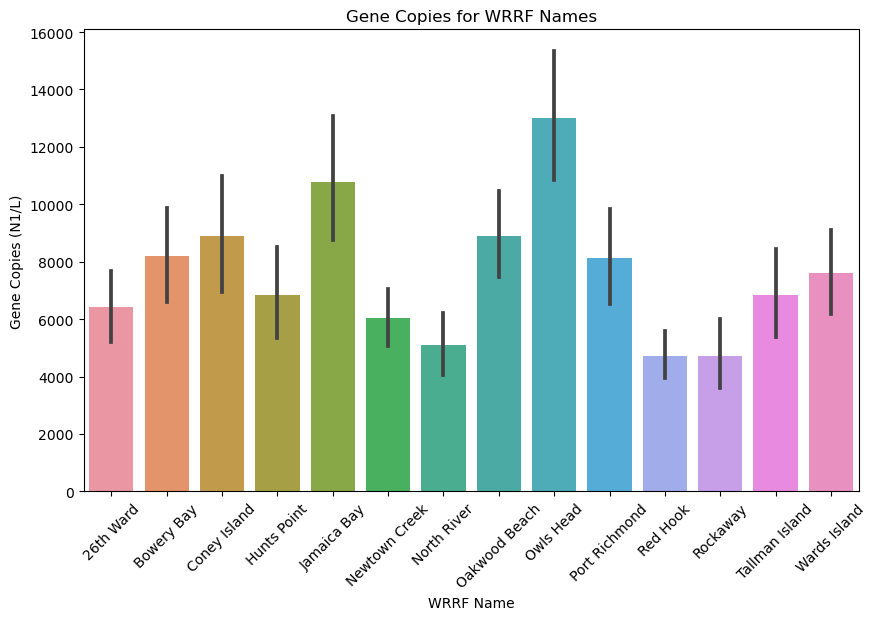

In [48]:
# Let's get to visualizing some of this!


plt.figure(figsize=(10, 6))
sns.barplot(x='WRRF Name', y='Gene Copies (N1/L)', data=merged_df_pre_omi)
plt.xlabel('WRRF Name')
plt.ylabel('Gene Copies (N1/L)')
plt.title('Gene Copies for WRRF Names')
plt.xticks(rotation=45)
plt.show()



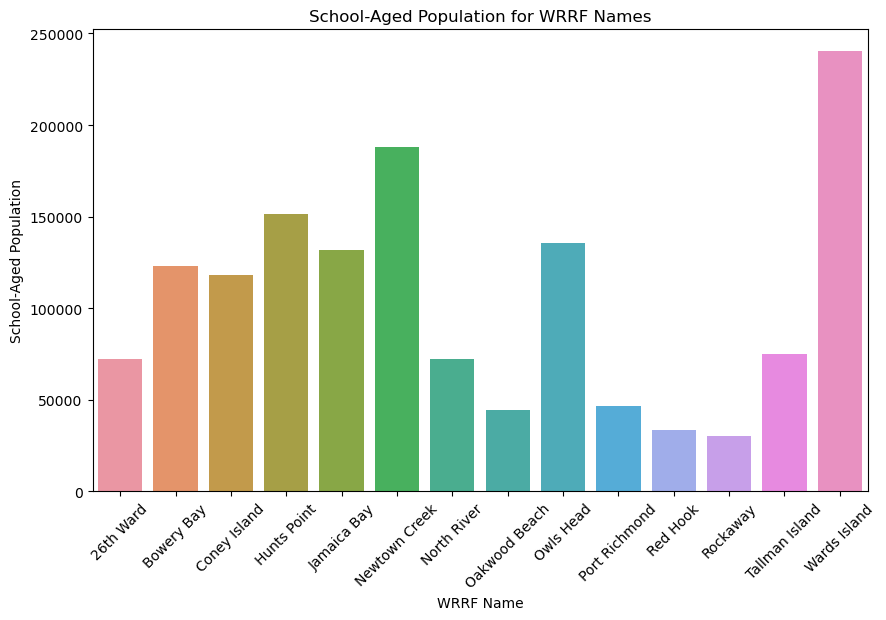

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='WRRF Name', y='School-Aged Population', data=merged_df_pre_omi)
plt.xlabel('WRRF Name')
plt.ylabel('School-Aged Population')
plt.title('School-Aged Population for WRRF Names')
plt.xticks(rotation=45)
plt.show()

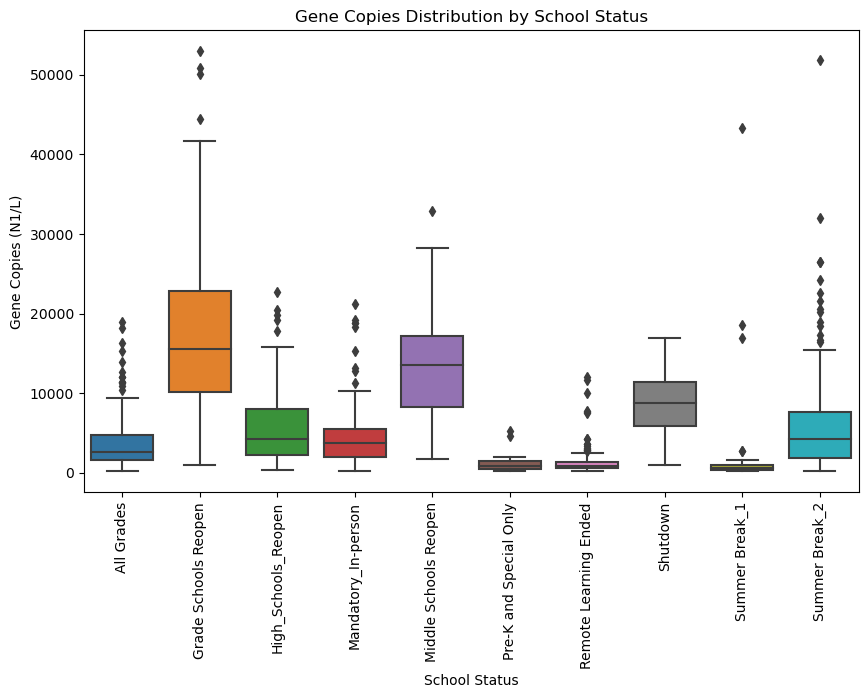

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='School Status', y='Gene Copies (N1/L)', data=merged_df_pre_omi)
plt.xlabel('School Status')
plt.ylabel('Gene Copies (N1/L)')
plt.title('Gene Copies Distribution by School Status')
plt.xticks(rotation=90)
plt.show()


In [51]:
corr = merged_df_pre_omi.select_dtypes("number").corr()
corr

,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School-Aged Population
Gene Copies (N1/L),1.000000,0.941744,0.090130,0.081454
Per Capita Gene Copies,0.941744,1.000000,0.077998,0.103465
"Population Served, estimated",0.090130,0.077998,1.000000,0.942453
School-Aged Population,0.081454,0.103465,0.942453,1.000000


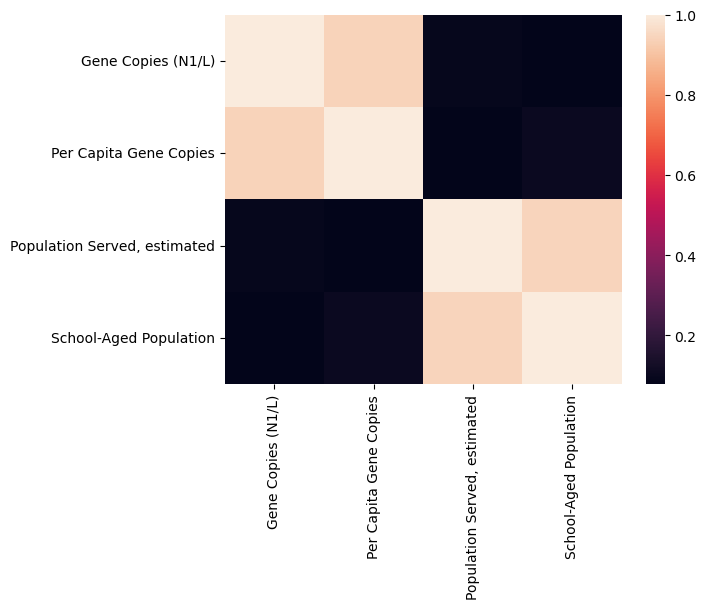

In [52]:
sns.heatmap(corr);

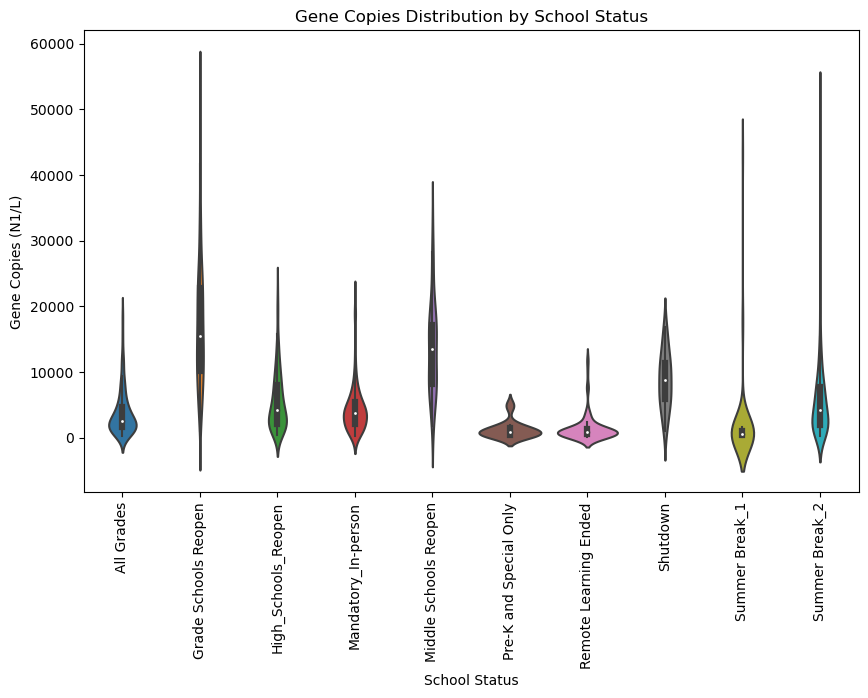

In [53]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='School Status', y='Gene Copies (N1/L)', data=merged_df_pre_omi)
plt.xlabel('School Status')
plt.ylabel('Gene Copies (N1/L)')
plt.title('Gene Copies Distribution by School Status')
plt.xticks(rotation=90)
plt.show()

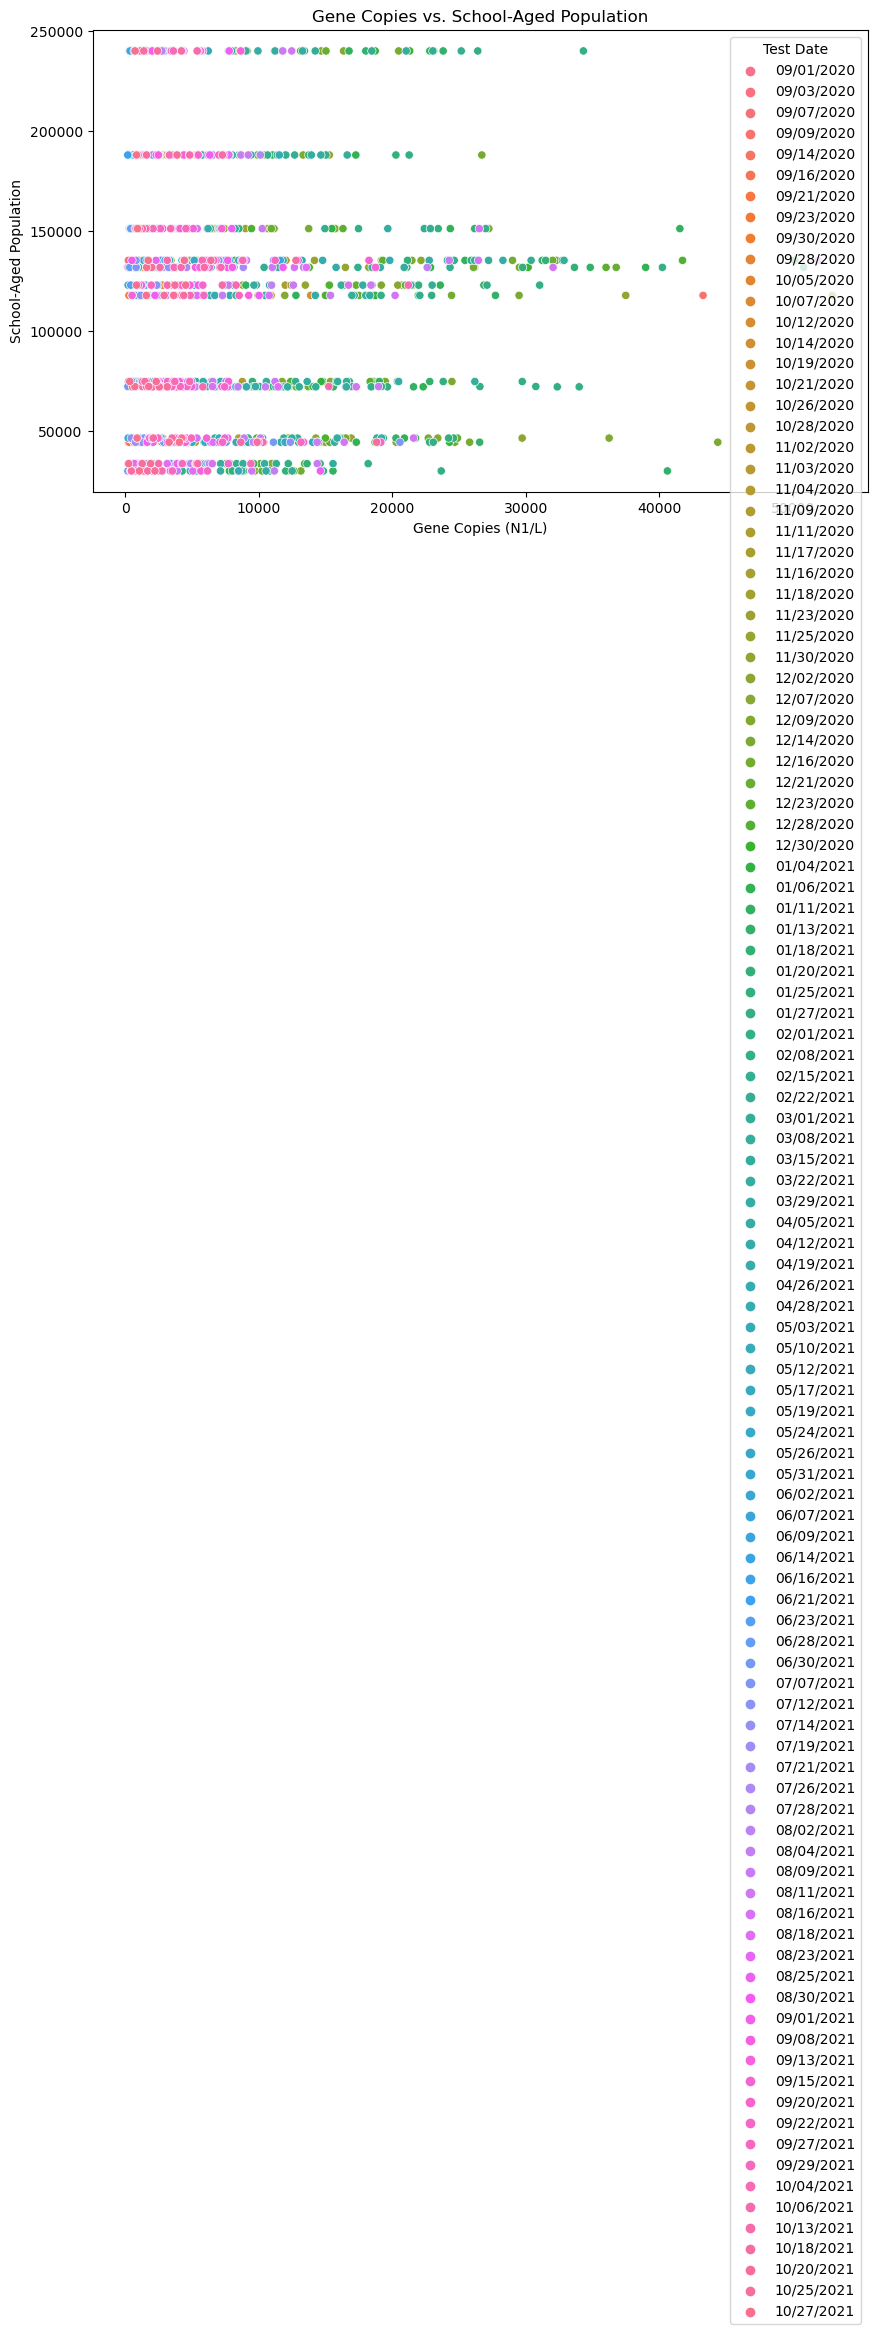

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gene Copies (N1/L)', y='School-Aged Population', hue='Test Date', data=merged_df_pre_omi)
plt.xlabel('Gene Copies (N1/L)')
plt.ylabel('School-Aged Population')
plt.title('Gene Copies vs. School-Aged Population')
plt.show()

In [55]:
# Dropping irrelevant columns
merged_df_pre_omi.drop(['Annotation', 'WRRF Abbreviation'], axis=1, inplace=True)

In [56]:
# This is all the data we ultimately might want to model, with the exception of Test Date (want to look at Sample Date
# instead) 
merged_df_pre_omi.head()

,Test Date,WRRF Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School Status,School-Aged Population
Sample Date,,,,,,,
2020-08-31,09/01/2020,26th Ward,389.0,263535.64,290608,Summer Break_1,72091.0
2020-08-31,09/01/2020,Bowery Bay,1204.0,443632.86,924695,Summer Break_1,122994.0
2020-08-31,09/01/2020,Coney Island,304.0,168551.56,682342,Summer Break_1,117865.0
2020-08-31,09/01/2020,Hunts Point,940.0,574446.57,755948,Summer Break_1,151282.0
2020-08-31,09/01/2020,Jamaica Bay,632.0,233077.74,748737,Summer Break_1,131881.0


In [57]:
# Creating a season column - we need to engineer a couple more features!

def get_season(date):
    if date.strftime('%Y-%m-%d') >= '2020-03-20' and date.strftime('%Y-%m-%d') <= '2020-09-21':
        return 'Summer 2020'
    elif date.strftime('%Y-%m-%d') >= '2020-09-22' and date.strftime('%Y-%m-%d') <= '2020-12-20':
        return 'Fall 2020'
    elif date.strftime('%Y-%m-%d') >= '2020-12-21' and date.strftime('%Y-%m-%d') <= '2021-03-19':
        return 'Winter 2020'
    elif date.strftime('%Y-%m-%d') >= '2021-03-20' and date.strftime('%Y-%m-%d') <= '2021-06-19':
        return 'Spring 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-06-20' and date.strftime('%Y-%m-%d') <= '2021-09-21':
        return 'Summer 2021'
    else: 
        return 'Fall 2021'

merged_df_pre_omi.index = pd.to_datetime(merged_df_pre_omi.index)

merged_df_pre_omi['Season'] = merged_df_pre_omi.index.map(get_season)

merged_df_pre_omi.sample(5)

,Test Date,WRRF Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School Status,School-Aged Population,Season
Sample Date,,,,,,,,
2020-10-20,10/21/2020,Newtown Creek,5293.0,2979664.88,1156473,All Grades,188137.0,Fall 2020
2021-01-12,01/13/2021,Jamaica Bay,34826.0,13557353.52,748737,Grade Schools Reopen,131881.0,Winter 2020
2021-10-26,10/27/2021,Hunts Point,918.0,1566703.29,755948,Mandatory_In-person,151282.0,Fall 2021
2021-06-13,06/14/2021,Red Hook,1447.0,660176.91,224029,Remote Learning Ended,33636.0,Spring 2021
2020-12-20,12/21/2020,Oakwood Beach,24680.0,9460466.28,258731,Grade Schools Reopen,44374.0,Fall 2020


In [58]:
# Let's add some holidays.
import holidays
us_holidays = holidays.UnitedStates(years=[2020, 2021])

def is_holiday(date):
    return date in us_holidays



In [59]:
# Which holidays did this include? We want Jewish and Muslim holidays as well! This is NYC!



# Adding Major Jewish Holidays, 2020
us_holidays[datetime.date(2020, 9, 18)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2020, 9, 19)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2020, 9, 20)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2020, 9, 27)] = 'Yom Kippur'
us_holidays[datetime.date(2020, 9, 28)] = 'Yom Kippur'
us_holidays[datetime.date(2020, 10, 2)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 3)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 4)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 5)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 6)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 7)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 8)] = 'Sukkot'
us_holidays[datetime.date(2020, 10, 9)] = 'Sukkot'
us_holidays[datetime.date(2020, 12, 10)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 11)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 12)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 13)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 14)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 15)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 16)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 17)] = 'Chanukah'
us_holidays[datetime.date(2020, 12, 18)] = 'Chanukah'

In [60]:
# Adding Major Jewish Holidays, 2021
us_holidays[datetime.date(2021, 2, 25)] = 'Purim'
us_holidays[datetime.date(2021, 2, 26)] = 'Purim'
us_holidays[datetime.date(2021, 3, 27)] = 'Passover'
us_holidays[datetime.date(2021, 3, 28)] = 'Passover'
us_holidays[datetime.date(2021, 3, 29)] = 'Passover'
us_holidays[datetime.date(2021, 3, 30)] = 'Passover'
us_holidays[datetime.date(2021, 4, 1)] = 'Passover'
us_holidays[datetime.date(2021, 4, 2)] = 'Passover'
us_holidays[datetime.date(2021, 4, 3)] = 'Passover'
us_holidays[datetime.date(2021, 4, 4)] = 'Passover'
us_holidays[datetime.date(2021, 5, 16)] = 'Shavuot'
us_holidays[datetime.date(2021, 5, 17)] = 'Shavuot'
us_holidays[datetime.date(2021, 5, 18)] = 'Shavuot'
us_holidays[datetime.date(2021, 9, 6)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2021, 9, 7)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2021, 9, 8)] = 'Rosh Hoshanah'
us_holidays[datetime.date(2021, 9, 15)] = 'Yom Kippur'
us_holidays[datetime.date(2021, 9, 16)] = 'Yom Kippur'
us_holidays[datetime.date(2021, 9, 20)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 21)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 22)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 23)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 24)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 25)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 26)] = 'Sukkot'
us_holidays[datetime.date(2021, 9, 27)] = 'Sukkot'
us_holidays[datetime.date(2021, 11, 28)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 29)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 30)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 1)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 2)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 3)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 4)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 5)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 6)] = 'Chanukah'

In [61]:
# Adding Islamic holidays, 2020  ( need to do more research. don't have a great understanding of how commonly
#they are celebrated - i know ramadan and eid, but unsure how many days are typically celebrated)
merged_df_pre_omi['Holiday'] = merged_df_pre_omi.index.map(is_holiday).astype(int)

merged_df_pre_omi['Holiday'].value_counts()

0    1302
1     182
Name: Holiday, dtype: int64

In [62]:
# before modelling, let's save our data as csv

merged_df_pre_omi.to_csv('data/pre_omi.csv', index=False)

# Preprocessing and Modelling Pre-Omicron

In [63]:
# When I did my first modelling, I did not ensure I had the proper data type for all columns; this
# resulted in "Test Date" (previously encoded as an object) being assigned to cat_cols and subsquently onehot encoded,
# inflating my scores. This is resolved below. Scores were previously about 10 percentage points higher on simple
# linear models.

merged_df_pre_omi['Test Date'] = pd.to_datetime(merged_df_pre_omi['Test Date'])

merged_df_pre_omi['School Status'] = merged_df_pre_omi['School Status'].astype('object')
merged_df_pre_omi['School-Aged Population']

Sample Date
2020-08-31     72091.0
2020-08-31    122994.0
2020-08-31    117865.0
2020-08-31    151282.0
2020-08-31    131881.0
                ...   
2021-10-26     46435.0
2021-10-26     33636.0
2021-10-26     29986.0
2021-10-26     74748.0
2021-10-26    240219.0
Name: School-Aged Population, Length: 1484, dtype: float64

In [64]:
# Simple preprocessing. Not going to worry about scaling right now. Just attempting to determine if my data is
# strong enough to warrant continuing.

cat_cols = []

for i in merged_df_pre_omi.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Test Date':
        pass
    elif merged_df_pre_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif merged_df_pre_omi[i].dtype == 'float64' or 'int64':
        print(i)
    else:
        print("error")


cat_transformer = Pipeline(steps=[  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
    ])

y = merged_df_pre_omi['Gene Copies (N1/L)']

X = merged_df_pre_omi.drop('Gene Copies (N1/L)', axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


Per Capita Gene Copies
Population Served, estimated
School-Aged Population
Holiday


In [65]:
# Setting up columns to be onehot encoded. We will look at numerical transformation later




# Have to drop the NaNs, otherwise linear model won't work
y_train = y_train.dropna()
X_train = X_train.dropna()
X_test = X_test.dropna()
y_test = y_test.dropna()

In [66]:
linreg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg.fit(X_train, y_train)


y_pred=linreg.predict(X_test)

linreg.score(X_train,y_train)



0.5587991188685084

In [67]:
linear_model = linreg.named_steps['model']

# Print the coefficients along with column names
for feature_name, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature_name}: {coef}")

Test Date: -1070.2982270060952
WRRF Name: 1000.1580037146778
Per Capita Gene Copies: 1133.043333951316
Population Served, estimated: -729.9289403163428
School Status: 3534.929886399773
School-Aged Population: -1595.292150257837
Season: -2604.654484580207
Holiday: 1246.104726306294


In [68]:
# Let's try again but with log-transformed targets
y_train_2 = np.log(y_train)
y_test_2 = np.log(y_test)

In [69]:
linreg_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg_2.fit(X_train, y_train_2)

y_pred_2=linreg_2.predict(X_test)

linreg_2.score(X_train,y_train_2)



0.631971730326365

In [70]:
linear_model = linreg_2.named_steps['model']

# Print the coefficients along with column names
for feature_name, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature_name}: {coef}")

Test Date: -0.0440007780691526
WRRF Name: 0.20732123218866916
Per Capita Gene Copies: 0.19162232107698013
Population Served, estimated: -0.14624733932704054
School Status: 0.31736815887438546
School-Aged Population: -0.1297000508508879
Season: -0.3831365358061128
Holiday: 0.4055824921338149


In [71]:
# with the addition of jewish holidays, got a 1% boost in the r2 score. might get a little nudge with islamic, but
# probably not much (not reflected in the notebook, as I over-wrote it)

In [72]:
copy_df = merged_df_pre_omi.copy()

copy_df.dropna(inplace=True)

y = copy_df['Gene Copies (N1/L)']


X = copy_df.drop(columns=['Gene Copies (N1/L)','Population Served, estimated', 'Per Capita Gene Copies'], axis=1)

# Split again
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Log transforming the target

y_test = np.log(y_test)
y_train = np.log(y_train)

In [73]:
# 3rd iteration, no adjustments to the model itself

linreg_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linreg_3.fit(X_train, y_train)

y_pred = linreg_3.predict(X_test)

linreg_3.score(X_train,y_train)

0.6177258476117596

In [74]:
linear_model = linreg_3.named_steps['model']

# Print the coefficients along with column names
for feature_name, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature_name}: {coef}")

Test Date: -0.14757150645203634
WRRF Name: 0.17730798873563733
School Status: 0.21434747417862648
School-Aged Population: -0.1206607271795389
Season: 0.28797817715926266
Holiday: -0.1298456319366709


In [75]:
# Slightly worse score without the non-school (basic) population data

In [76]:
# Let's look at just the school-related info.
copy_df_2 = merged_df_pre_omi.copy()
copy_df_2.dropna(inplace=True)
y = copy_df_2['Gene Copies (N1/L)']

X = copy_df_2[['School-Aged Population', 'School Status']]



# We only have one column to transform in this version

cat_cols_2 = ['School Status']

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols_2),
    ])

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [77]:
# 4th model - this one is actually different!

linreg_4 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('model', LinearRegression())
])

linreg_4.fit(X_train, y_train)

y_pred = linreg_4.predict(X_test)

linreg_4.score(X_train,y_train)

0.46997170371988195

In [78]:
# Ok, so with just the school-aged population and school status, our model explains nearly half the variance! And this
# is before log transformation!


In [79]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [80]:
# Same model, different data

linreg_5 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('model', LinearRegression())
])

linreg_5.fit(X_train, y_train)

y_pred = linreg_5.predict(X_test)

print(linreg_5.score(X_train,y_train))
print(r2_score(y_test, y_pred))

0.5422711234817856
0.5143954687950946


In [81]:
# Ok, our train tests scores are pretty close! Not too much overfitting.


In [82]:
# New X and y

copy_df_3 = merged_df_pre_omi.copy()
copy_df_3.dropna(inplace=True)
y = copy_df_3['Gene Copies (N1/L)']

X = copy_df_3['School-Aged Population']


# Split again

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# log transform again

y_train = np.log(y_train)
y_test = np.log(y_test)

In [83]:
# using ols because we are not preprocessing this data


X_int = sm.add_constant(X_train)
results = sm.OLS(y_train, X_int).fit()
summary = results.summary()
print(summary)

influence = OLSInfluence(results)
print(influence.resid_studentized)

# well, this isn't very good! This is just school-aged population, though, and not the actual status of schools

                            OLS Regression Results                            
Dep. Variable:     Gene Copies (N1/L)   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.238
Date:                Fri, 28 Jul 2023   Prob (F-statistic):            0.00418
Time:                        15:56:58   Log-Likelihood:                -1784.3
No. Observations:                1097   AIC:                             3573.
Df Residuals:                    1095   BIC:                             3583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8

In [84]:
# Wonder how predictive the baseline model is. Let's just look at the original population data!

In [85]:

copy_df_4 = merged_df_pre_omi.copy()
copy_df_4.dropna(inplace=True)
y = copy_df_4['Gene Copies (N1/L)']

X = copy_df_4['Population Served, estimated']

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [86]:
X_int = sm.add_constant(X_train)
model_2 = sm.OLS(y_train, X_int).fit()
summary = model_2.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Gene Copies (N1/L)   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.33
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           0.000791
Time:                        15:56:59   Log-Likelihood:                -1782.7
No. Observations:                1097   AIC:                             3569.
Df Residuals:                    1095   BIC:                             3579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.0670      0.075    106.995      0.000       7.919       8.215
Population Served, estimated  3.618e-07   1.08e-07      3.365      0.001    1.51e-07    5.73e-07
==============================================================================
Omnibus:                       61.143   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.686
Skew:                          -0.330   Prob(JB):                     3.98e-09
Kurtosis:                       2.359   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
copy_df_5 = merged_df_pre_omi.copy()
copy_df_5.reset_index()
copy_df_5.dropna(inplace=True)
y = copy_df_5['Gene Copies (N1/L)']

X = copy_df_5[['Population Served, estimated', 'WRRF Name', 'Per Capita Gene Copies', 'Test Date']]

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


y_train = np.log(y_train)
y_test = np.log(y_test)

In [88]:
cat_transformer = Pipeline(steps=[  
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))                     
])

cat_cols_3 = ['WRRF Name']

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols_3),
    ])


linreg_6 = Pipeline([
    ('preprocessor', preprocessor_3),
    ('model', LinearRegression())
])

linreg_6.fit(X_train, y_train)

y_pred = linreg_6.predict(X_test)

print(linreg_6.score(X_train,y_train))
print(r2_score(y_test, y_pred))

0.07123753415992828
0.04505102157812135


In [89]:
# So yeah, the basic info from the original dataset explains almost nothing. 

In [90]:
# Want to use the index as a feature. Let's also save this data file as a csv, since
# it's what we ultimately want to use.

sample_date_df = merged_df_pre_omi.copy()

# sample_date_df.to_csv('data/master_wastewater.csv', index=False)

sample_date_df = sample_date_df.reset_index()
sample_date_df

,Sample Date,Test Date,WRRF Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School Status,School-Aged Population,Season,Holiday
0,2020-08-31,2020-09-01,26th Ward,389.0,263535.64,290608,Summer Break_1,72091.0,Summer 2020,0
1,2020-08-31,2020-09-01,Bowery Bay,1204.0,443632.86,924695,Summer Break_1,122994.0,Summer 2020,0
2,2020-08-31,2020-09-01,Coney Island,304.0,168551.56,682342,Summer Break_1,117865.0,Summer 2020,0
3,2020-08-31,2020-09-01,Hunts Point,940.0,574446.57,755948,Summer Break_1,151282.0,Summer 2020,0
4,2020-08-31,2020-09-01,Jamaica Bay,632.0,233077.74,748737,Summer Break_1,131881.0,Summer 2020,0
...,...,...,...,...,...,...,...,...,...,...
1479,2021-10-26,2021-10-27,Port Richmond,881.0,560091.38,226167,Mandatory_In-person,46435.0,Fall 2021,0
1480,2021-10-26,2021-10-27,Red Hook,250.0,392726.56,224029,Mandatory_In-person,33636.0,Fall 2021,0
1481,2021-10-26,2021-10-27,Rockaway,1052.0,991360.72,120539,Mandatory_In-person,29986.0,Fall 2021,0
1482,2021-10-26,2021-10-27,Tallman Island,336.0,387871.66,449907,Mandatory_In-person,74748.0,Fall 2021,0


In [91]:
# Fancier models! Going to move on to more elaborate models, including Random Forest.

# Re-doing the columns for preprocessing
date_cols = []
cat_cols = []  
num_cols = []   

for i in sample_date_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass
    elif sample_date_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        date_cols.append(i)
    elif sample_date_df[i].dtype == 'float64' or sample_date_df[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        


print(date_cols)
print(cat_cols)
print(num_cols)
# leaving "holiday" out because we don't want to transform this binary data

['Sample Date', 'Test Date']
['WRRF Name', 'School Status', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


In [92]:
class ColumnSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]
    

In [93]:
# New X and y, split

sample_copy_df = sample_date_df.copy()
sample_copy_df.dropna(inplace=True)

X = sample_copy_df.drop('Gene Copies (N1/L)', axis=1)

y = sample_copy_df['Gene Copies (N1/L)']


X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)


In [94]:
# New preprocessors

cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

# datetime_preprocessor = Pipeline([
#     ('date_transform', FunctionTransformer(func=DateTransformer().transform))
# ])


preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
#     ('datetime', datetime_preprocessor, date_cols)  # Apply DateTransformer to datetime column
])


rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  RandomForestRegressor(random_state = 42))
])





In [95]:

# Just going with a vanilla Random Forest model after trying to combine a linear regression and random forest...
rf_pipeline.fit(X_train, y_train)


y_pred = rf_pipeline.predict(X_test)

print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9951082673198972
R2 test score: 0.9675638498965449
Mean squared error: 0.052094098364203714
Mean absolute error: 0.15678014488775047
Mean absolute percentage error: 0.019586285838186914
Explained variance score (modified R2): 0.9675841799049261


In [96]:
# holy shit, 99.5%! 

In [97]:
# Cross-validating, because we ultimately want to use this on other data!
cross_validate(rf_pipeline, X_train, y_train, return_train_score=True)

{'fit_time': array([0.82338929, 0.8244822 , 0.85215521, 0.81571102, 0.80359411]),
 'score_time': array([0.01574469, 0.01576591, 0.01612282, 0.01672292, 0.01635098]),
 'test_score': array([0.97273797, 0.96571812, 0.96220805, 0.96419641, 0.95084884]),
 'train_score': array([0.99458214, 0.99494814, 0.99498579, 0.99466468, 0.99549897])}

In [98]:
# Let's look at feature importances of this model
rf_model = rf_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, rf_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.0033534293203989632: Sample Date
0.0013350698361288351: Holiday
0.0013342269200147376: Test Date
0.001027440180672196: School-Aged Population
0.00101529776794821: Season
0.0008777949385026092: Population Served, estimated
0.0006330406638788463: Per Capita Gene Copies
0.00044756918311024147: WRRF Name
0.00036113194992653256: School Status


In [99]:
# Want to try this model again without the date features, since they seem to be over-determining.

sample_copy_df_2 = sample_date_df.copy()

sample_copy_df_2.dropna(inplace=True)

X = sample_copy_df_2.drop(['Gene Copies (N1/L)', 'Sample Date', 'Test Date'], axis=1)

y = sample_copy_df_2['Gene Copies (N1/L)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [100]:
rf_pipeline.fit(X_train, y_train)  # Same pipeline, different data


y_pred = rf_pipeline.predict(X_test)


print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9951082673198972
R2 test score: 0.9675638498965449
Mean squared error: 0.052094098364203714
Mean absolute error: 0.15678014488775047
Mean absolute percentage error: 0.019586285838186914
Explained variance score (modified R2): 0.9675841799049261


In [101]:
# The very same! Our engineered features are very strong all around. Let's look at feature importance.

rf_model = rf_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, rf_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.0033534293203989632: WRRF Name
0.0013342269200147376: Per Capita Gene Copies
0.001027440180672196: Holiday
0.0008777949385026092: School-Aged Population
0.0006330406638788463: School Status
0.00044756918311024147: Population Served, estimated
0.00036113194992653256: Season


In [102]:
# Let's try another model type, using all features

sample_copy_df = sample_date_df.copy()

X = sample_copy_df.drop('Gene Copies (N1/L)', axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X.dropna(inplace=True)
y.dropna(inplace=True)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [103]:

grad = GradientBoostingRegressor()
grad_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])


grad_pipeline.fit(X_train, y_train)
y_pred = grad_pipeline.predict(X_test)

print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9951082673198972
R2 test score: 0.9723010543567391
Mean squared error: 0.044485908294371296
Mean absolute error: 0.1442363448684338
Mean absolute percentage error: 0.01799470235445963
Explained variance score (modified R2 test score): 0.9723059962274365


In [104]:
# Pretty similar!

In [105]:
grad_model = grad_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.003964230615167441: Sample Date
0.001854623725073642: Holiday
0.0010896138197174733: School-Aged Population
0.0007372886446107495: Season
0.0006791720086939145: Population Served, estimated
0.0004589845674212517: Test Date
0.0003816646083538937: Per Capita Gene Copies
1.2022278342754647e-05: School Status
9.79120009423618e-06: WRRF Name


In [106]:
# Very different weighing of features here, and slightly better test score. Let's look at loss scores, too:
train_score = grad_pipeline['model'].train_score_
train_score


# If we ran maybe double the iteratations, our loss score should approach .2

array([1.2546271 , 1.0343755 , 0.85524127, 0.70958707, 0.59109145,
       0.4945883 , 0.41586988, 0.35165381, 0.29935438, 0.25651436,
       0.221891  , 0.19355449, 0.17034788, 0.15123911, 0.13525078,
       0.12200857, 0.11088258, 0.10184361, 0.09408602, 0.08763019,
       0.08227315, 0.07697006, 0.07258206, 0.0690886 , 0.06602022,
       0.06324645, 0.06088238, 0.05882038, 0.05690847, 0.05521488,
       0.05357605, 0.05218039, 0.05038489, 0.04914069, 0.04801434,
       0.04685401, 0.04577433, 0.04487213, 0.04399308, 0.04311993,
       0.0423678 , 0.04161209, 0.04089222, 0.03969664, 0.03909103,
       0.03846022, 0.03794208, 0.03745044, 0.03702689, 0.03632175,
       0.03593234, 0.03559401, 0.03521393, 0.03492283, 0.03463449,
       0.0343394 , 0.03404891, 0.03374259, 0.03347791, 0.03326131,
       0.03307398, 0.03287956, 0.03270017, 0.0324756 , 0.03231803,
       0.03210624, 0.03182856, 0.03168736, 0.03153384, 0.03138392,
       0.0312248 , 0.03109716, 0.03097769, 0.03087304, 0.03076

In [107]:
# Let's get rid of all date columns with this model and see what happens

sample_copy_df = sample_date_df.copy()

X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date'], axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X.dropna(inplace=True)
y.dropna(inplace=True)

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [108]:
grad = GradientBoostingRegressor()
grad_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])

grad_pipeline.fit(X_train, y_train)
y_pred = grad_pipeline.predict(X_test)

print(f'R-squared score on training data: {rf_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

R-squared score on training data: 0.9951082673198972
R2 test score: 0.9723010543567391
Mean squared error: 0.044485908294371296
Mean absolute error: 0.1442363448684338
Mean absolute percentage error: 0.01799470235445963
Explained variance score (modified R2 test score): 0.9723059962274365


In [109]:
grad_model = grad_pipeline.named_steps['model']
features = []
scores = []
# Print the coefficients along with column names
for feature_name, importance in zip(X.columns, grad_model.feature_importances_):
    features.append(feature_name)
    scores.append(importance)
    
ranked_scores = sorted(zip(scores, features), reverse=True)
for score, feature in ranked_scores:
    print(f'{score}: {feature}')

0.003964230615167447: WRRF Name
0.001089613819717467: Holiday
0.0006780813323552689: School-Aged Population
0.00045898456742125127: Per Capita Gene Copies
0.0003816646083538955: School Status
1.1101917699991657e-05: Season
9.79120009423618e-06: Population Served, estimated


In [110]:
# Removing the datetime info and re-running grid search

grad = GradientBoostingRegressor()
grad_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad)
])

param_grid = {
    'model__learning_rate': [.01, .1, .3],
    'model__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'model__n_estimators': [100, 150, 200, 250],
    'model__subsample': [.3, .5, .7, 1.0],
    'model__criterion': ['friedman_mse', 'squared_error']
    
}
                            
grid_search_gbc = GridSearchCV(
    estimator = grad_pipeline,  # pipeline 
    param_grid = param_grid,
    cv= 5,
    scoring='explained_variance'  # internal scoring term
)

grid_search_gbc.fit(X_train, y_train)

cv_score = grid_search_gbc.best_score_
test_score = r2_score(y_test, grid_search_gbc.predict(X_test))

print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print(grid_search_gbc.best_params_)

KeyboardInterrupt: 

In [111]:
# Thought I was done, but want to try one more model type: LinearTrees!
from scipy.sparse import csr_matrix
sample_copy_df = sample_date_df.copy()

sample_copy_df.dropna(inplace=True)

X = sample_copy_df.drop(columns=['Gene Copies (N1/L)','Sample Date', 'Test Date'], axis=1)

y = sample_copy_df['Gene Copies (N1/L)']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)

In [112]:
lintree = LinearTreeRegressor(base_estimator=LinearRegression())

lintree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_sparse', FunctionTransformer(csr_matrix, validate=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), validate=False)),
    ('model',  lintree)
])

lintree_pipeline.fit(X_train, y_train)

y_pred = lintree_pipeline.predict(X_test)

print(f'R-squared score on training data: {lintree_pipeline.score(X_train, y_train)}')
print(f'R2 test score: {r2_score(y_test, y_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred)}')
print(f'Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Explained variance score (modified R2 test score): {explained_variance_score(y_test, y_pred)}')

# Well, that was a terrible model for this data, but seemed interesting! 

R-squared score on training data: 0.9802052054633759
R2 test score: -1184.0720230715035
Mean squared error: 1903.285634751599
Mean absolute error: 3.5056331972161354
Mean absolute percentage error: 0.4220202108653636
Explained variance score (modified R2 test score): -1177.0278641925847


## Now we're going to see how well our model lines up against post-Omicron data, roughly
## established to have begun circulating November 2021 in NYC.

In [113]:
post_omi_df = pd.read_csv('data/SARS-CoV-2_concentrations_measured_in_NYC_Wastewater.csv')

post_omi_df.head()

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated"
0,08/31/2020,09/01/2020,26th Ward,26W,389.0,263535.64,Concentration below Method Limit of Quantifica...,290608
1,08/31/2020,09/01/2020,Bowery Bay,BB,1204.0,443632.86,NaN,924695
2,08/31/2020,09/01/2020,Coney Island,CI,304.0,168551.56,Concentration below Method Limit of Quantifica...,682342
3,08/31/2020,09/01/2020,Hunts Point,HP,940.0,574446.57,NaN,755948
4,08/31/2020,09/01/2020,Jamaica Bay,JA,632.0,233077.74,NaN,748737


In [114]:
# Basic cleaning of data
post_omi_df['Sample Date'] = pd.to_datetime(post_omi_df['Sample Date'])
post_omi_df['Test Date'] = pd.to_datetime(post_omi_df['Sample Date'])

# Filter the dataframe to include only dates after a certain date

post_omi_df = post_omi_df[post_omi_df['Sample Date'] > '2021-10-31']

# Drop same columns as before

# post_omi_df.drop(['Annotation', 'Test date', 'WRRF Abbreviation'], axis=1, inplace=True)

# Merge school pop and zipcode data 

post_omi_df['Total WRRF School-Aged Pop'] = post_omi_df['WRRF Name'].map(merged_df.groupby('WRRF Name')['Total WRRF Population'].first())

# Save as csv
post_omi_df.to_csv('data/merged_df_post_omi.csv', index=False)

In [119]:
merged_df_post_omi = pd.read_csv('data/merged_df_post_omi.csv')

In [121]:
# converting to datetime again? 
merged_df_post_omi['Sample Date'] = pd.to_datetime(merged_df_post_omi['Sample Date'])

# Exploring nulls

merged_df_post_omi.isnull().sum()

# Drop nulls since so few

merged_df_post_omi.dropna(inplace=True)

In [122]:
merged_df_post_omi.head()

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Test Date,Total WRRF School-Aged Pop
5,2021-11-02,11/03/2021,Newtown Creek,NC,2088.0,1257769.30,This sample was analyzed in duplicate. The hig...,1156473,2021-11-02,188137.0
14,2021-11-07,11/08/2021,26th Ward,26W,971.0,632608.93,This sample was analyzed in duplicate. The hig...,290608,2021-11-07,72091.0
25,2021-11-07,11/08/2021,Rockaway,RK,278.0,183500.50,Concentration below Method Limit of Quantifica...,120539,2021-11-07,29986.0
41,2021-11-14,11/15/2021,Wards Island,WI,4565.0,2315665.77,This sample was analyzed in duplicate. The hig...,1201485,2021-11-14,240219.0
48,2021-11-21,11/22/2021,North River,NR,5499.0,3002425.47,This sample was analyzed in duplicate. The hig...,658596,2021-11-21,72242.0


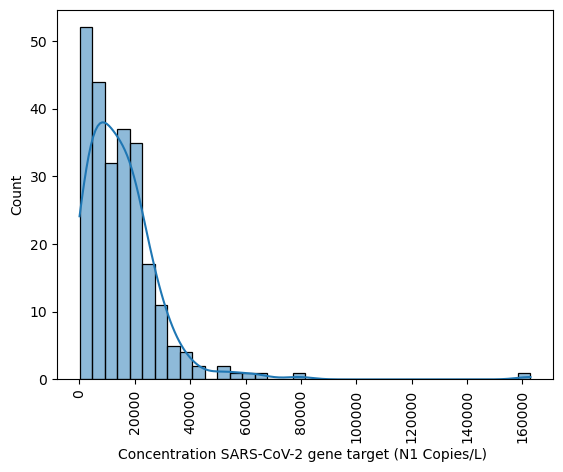

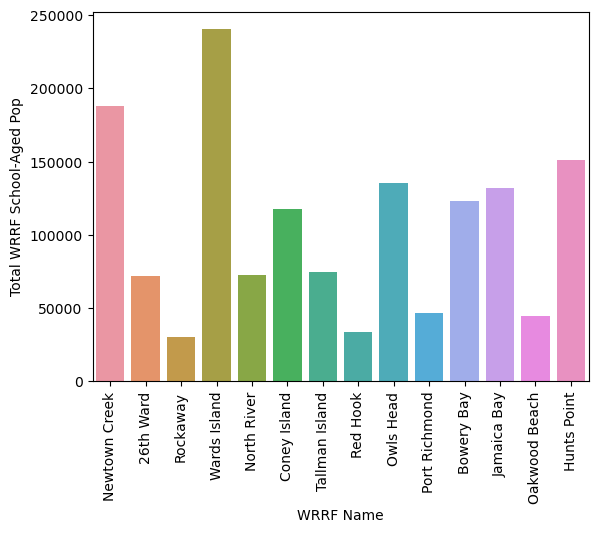

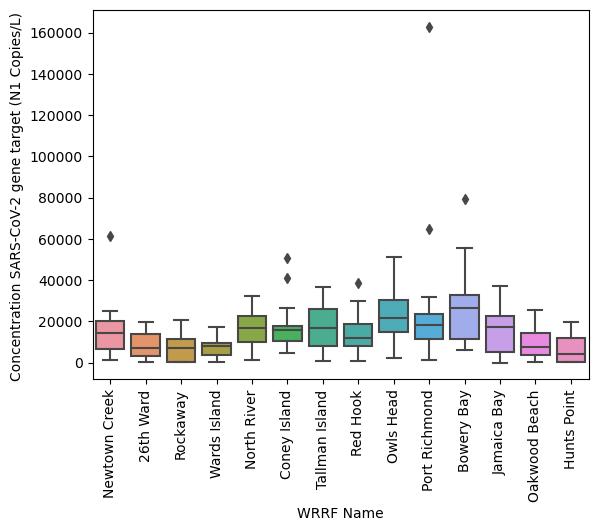

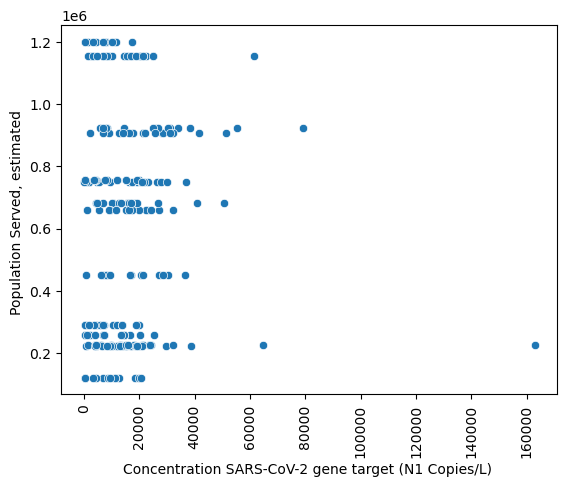

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_56282/1072077862.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df_post_omi.corr()


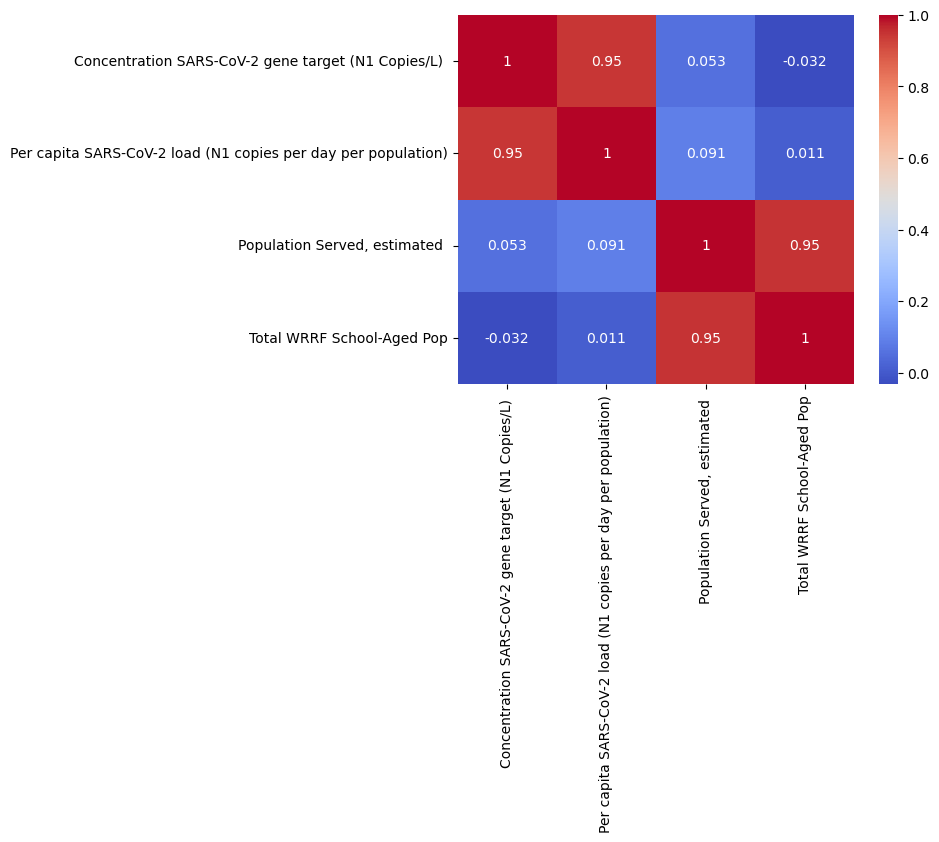

In [123]:
# Few visualizations. We already have a good idea of the general contours of this data and expect it to 
# diverge from pre-omicron


sns.histplot(data=merged_df_post_omi, x='Concentration SARS-CoV-2 gene target (N1 Copies/L) ', kde=True)
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=merged_df_post_omi, x='WRRF Name', y='Total WRRF School-Aged Pop')
plt.xticks(rotation=90)
plt.show()

sns.boxplot(data=merged_df_post_omi, x='WRRF Name', y='Concentration SARS-CoV-2 gene target (N1 Copies/L) ')
plt.xticks(rotation=90)
plt.show()


sns.scatterplot(data=merged_df_post_omi, x='Concentration SARS-CoV-2 gene target (N1 Copies/L) ', y='Population Served, estimated ')
plt.xticks(rotation=90)
plt.show()


corr = merged_df_post_omi.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()




# Modelling Post-Omicron 

In [124]:

# Removing date and target info. Date info too over-determining.

X = merged_df_post_omi.drop(columns=['Concentration SARS-CoV-2 gene target (N1 Copies/L) ', 'Sample Date'], axis=1)
y = merged_df_post_omi['Concentration SARS-CoV-2 gene target (N1 Copies/L) ']



X_train_2 ,X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.20, random_state=42)

# log transform
y_train_2 = np.log(y_train_2)
y_test_2 = np.log(y_test_2)

In [125]:
# Now, we would like to go back and add in seasons, holidays, etc for this period, but out of curiosity, let's
# see how our model works on just this data. We want to do the same transformations as before, but our features
# are a bit different, so let's account for that.


# Re-doing the columns 
date_cols = []
cat_cols = []  
num_cols = []   

for i in merged_df_post_omi.columns:
    if i == 'Concentration SARS-CoV-2 gene target (N1 Copies/L) ' or i == 'Sample Date':
        pass
    elif merged_df_post_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif merged_df_post_omi[i].dtype == 'float64' or 'int64':
        num_cols.append(i)
    else:
        print("error")
        


In [126]:
cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=250, subsample=0.7, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train_2, y_train_2)

y_pred_2 = grad_2_pipeline.predict(X_test_2)

train_score = grad_2_pipeline.score(X_train_2, y_train_2)
print(train_score)

test_score = r2_score(y_test_2, y_pred_2)
print(test_score)

0.9886637158893772
0.9760422934101896


In [127]:
cross_validate(grad_2_pipeline, X_train_2, y_train_2, return_train_score=True)

{'fit_time': array([0.53836799, 0.55516219, 0.5316093 , 0.5345118 , 0.51118183]),
 'score_time': array([0.00595999, 0.00634289, 0.00605583, 0.00612712, 0.00612187]),
 'test_score': array([0.95849074, 0.92194632, 0.97625557, 0.93479769, 0.95186411]),
 'train_score': array([0.99373289, 0.99131222, 0.99290983, 0.99237937, 0.98854089])}

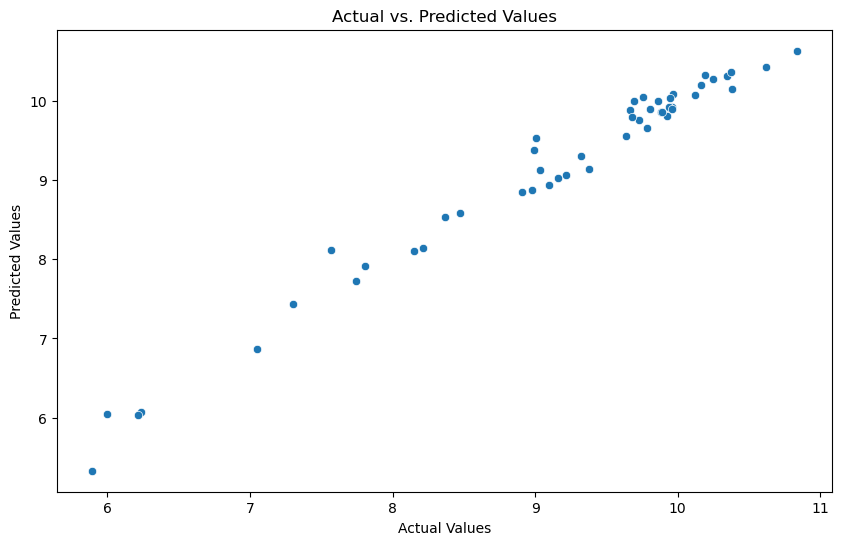

In [128]:
# Not horrible over all

# Let's visualize! Want to look at real vs predicted values as well as residuals and their distributions


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_2, y=y_pred_2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

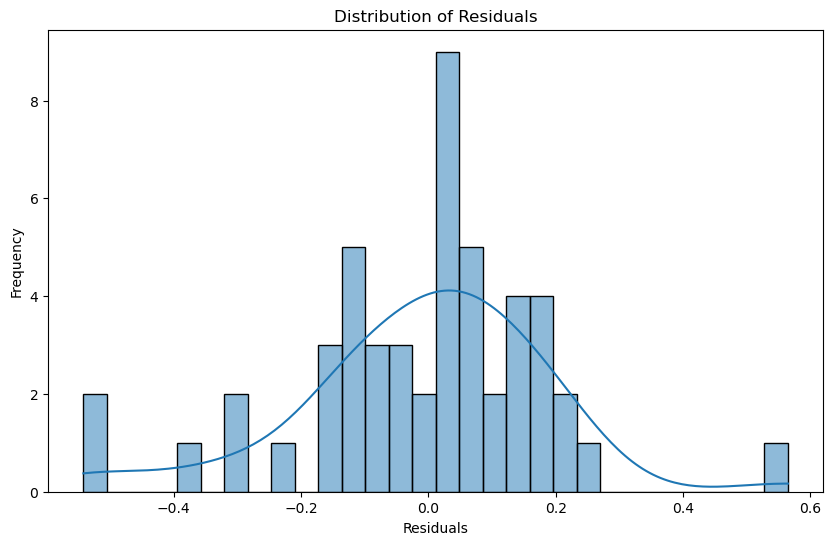

In [129]:
residuals = y_test_2 - y_pred_2

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

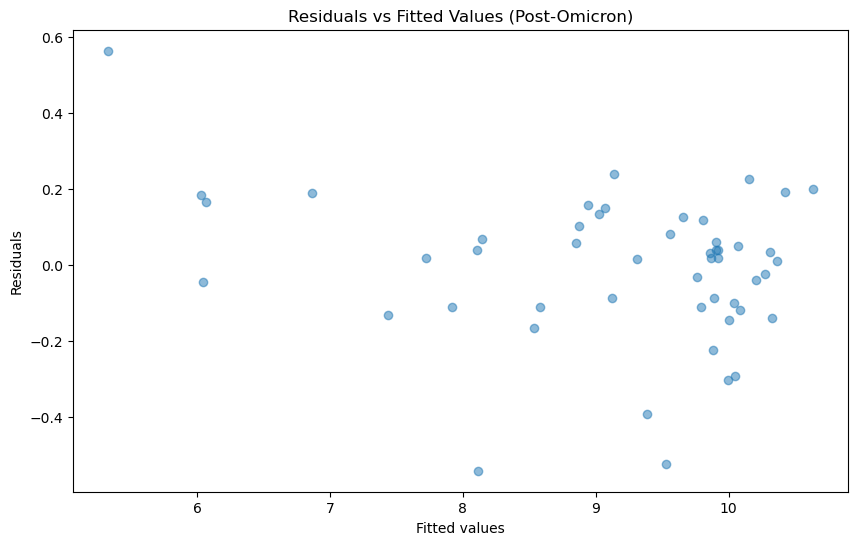

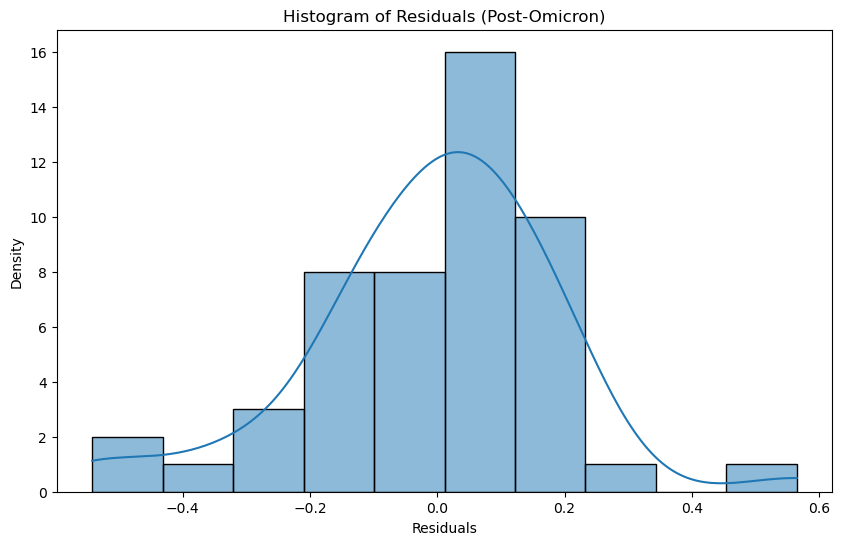

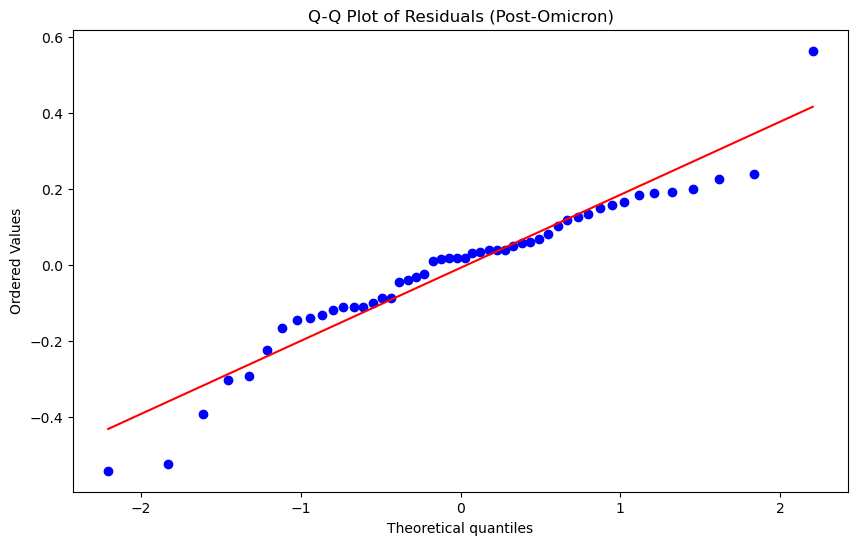

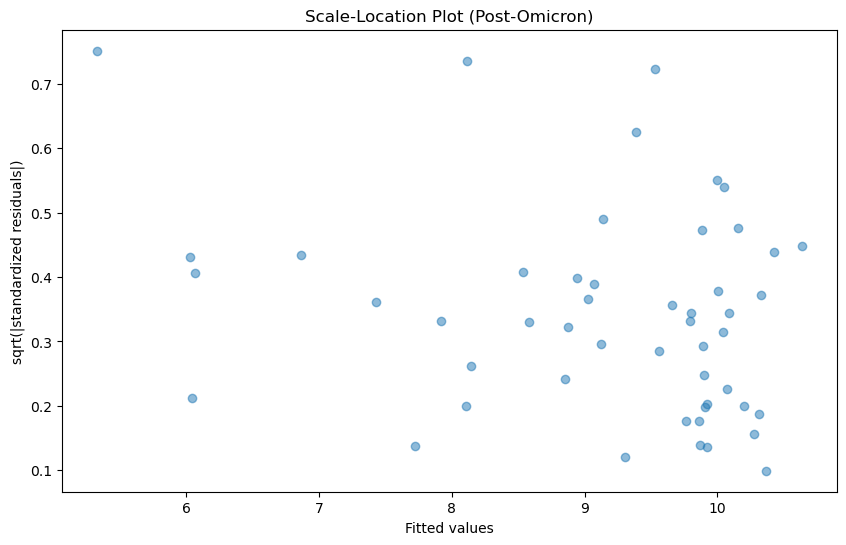

In [130]:
# Whole bunch of plots analyzing residuals :


# calculate residuals
residuals_2 = y_test_2 - y_pred_2



plt.figure(figsize=(10, 6))
plt.scatter(y_pred_2, residuals_2, alpha=0.5)
plt.title('Residuals vs Fitted Values (Post-Omicron)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(residuals_2, kde=True)
plt.title('Histogram of Residuals (Post-Omicron)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


plt.figure(figsize=(10, 6))
stats.probplot(residuals_2, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Post-Omicron)')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_2, np.sqrt(np.abs(residuals_2)), alpha=0.5)
plt.title('Scale-Location Plot (Post-Omicron)')
plt.xlabel('Fitted values')
plt.ylabel('sqrt(|standardized residuals|)')
plt.show()


In [131]:
merged_df_post_omi.describe()

,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),"Population Served, estimated",Total WRRF School-Aged Pop
count,246.000000,2.460000e+02,2.460000e+02,246.000000
mean,15178.141870,7.304668e+06,6.192468e+05,105206.650407
std,15313.638767,6.542568e+06,3.521403e+05,59969.526335
min,30.000000,1.120000e+04,1.205390e+05,29986.000000
25%,6220.750000,2.802500e+06,2.587310e+05,46435.000000
50%,12880.545000,6.330000e+06,6.823420e+05,117865.000000
75%,20549.500000,9.877500e+06,9.064420e+05,135396.000000
max,162949.000000,6.000083e+07,1.201485e+06,240219.000000


In [132]:
merged_df_pre_omi.describe()

,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School-Aged Population,Holiday
count,1372.000000,1.372000e+03,1.484000e+03,1484.000000,1484.000000
mean,7603.971574,3.805500e+06,6.146214e+05,104377.571429,0.122642
std,8191.959369,4.020042e+06,3.455093e+05,59999.322192,0.328136
min,181.000000,6.897697e+04,1.205390e+05,29986.000000,0.000000
25%,1619.750000,8.795711e+05,2.587310e+05,46435.000000,0.000000
50%,4532.500000,2.217354e+06,6.704690e+05,96306.500000,0.000000
75%,10836.750000,5.631582e+06,9.064420e+05,135396.000000,0.000000
max,52960.000000,2.677995e+07,1.201485e+06,240219.000000,1.000000


In [133]:
# Going to try both datasets again using sklearn.preprocessing.RobustScaler. Seems like might be useful given outliers?


In [134]:
# Setting up for RobustScaler on pre-omicron


merged_df_pre_omi.dropna(inplace=True)
y = merged_df_pre_omi['Gene Copies (N1/L)']
X =  merged_df_pre_omi.drop(columns=['Gene Copies (N1/L)', 'Test Date'], axis=1) # dropping datetime info again


X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)



In [135]:
# Re-adjusting data types for preprocessing
cat_cols = []  
num_cols = []   

for i in merged_df_pre_omi.columns:
    if i == 'Gene Copies (N1/L)':
        pass
    elif i == 'Holiday':
        pass
    elif i == 'Test Date':
        pass
    elif merged_df_pre_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif merged_df_pre_omi[i].dtype == 'float64' or 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(cat_cols)
print(num_cols)

['WRRF Name', 'School Status', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


In [136]:
# Adjusting preprocessing steps

numeric_preprocessor_2 = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', RobustScaler())
])

preprocessor_4 = ColumnTransformer([   # This is our 4th preprocesser!
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor_2, num_cols),
])



# Setting up 3rd iteration of best model, with pre-omi data

grad_3 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=250, subsample=0.5, random_state=42)
grad_3_pipeline = Pipeline([
    ('preprocessor', preprocessor_4),
    ('model',  grad_3)
])

grad_3_pipeline.fit(X_train, y_train)

y_pred_3 = grad_3_pipeline.predict(X_test)

train_score = grad_3_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred_3)
print(test_score)

0.9785062032668426
0.9729478894907363


In [137]:
cross_validate(grad_3_pipeline, X_train, y_train, return_train_score=True)

{'fit_time': array([0.71536899, 0.71746302, 0.68651175, 0.69569778, 0.68639302]),
 'score_time': array([0.00781369, 0.00727391, 0.00691509, 0.00689721, 0.00700188]),
 'test_score': array([0.97650998, 0.96798257, 0.97197615, 0.97522234, 0.96203852]),
 'train_score': array([0.97750871, 0.97941574, 0.97955954, 0.97831249, 0.98068566])}

In [138]:
# Well, we got very similar scores RobustScaler()! Wonder how much this would affect the post-Omicron data.

X = merged_df_post_omi.drop(columns=['Concentration SARS-CoV-2 gene target (N1 Copies/L) ', 'Sample Date'], axis=1)
y = merged_df_post_omi['Concentration SARS-CoV-2 gene target (N1 Copies/L) ']


X_train_2 ,X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.20, random_state=42)

y_train_2 = np.log(y_train_2)
y_test_2 = np.log(y_test_2)


In [139]:
# Adjusting preprocessing columns for post-omi

cat_cols = []  
num_cols = []   

for i in merged_df_post_omi.columns:
    if i == 'Concentration SARS-CoV-2 gene target (N1 Copies/L) ':
        pass
    elif merged_df_post_omi[i].dtype == 'object':
        cat_cols.append(i)
    elif i == 'Sample Date':
        pass
    elif merged_df_post_omi[i].dtype == 'float64' or 'int64':
        num_cols.append(i)
    else:
        print("error")
        


In [140]:
numeric_preprocessor_2 = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', RobustScaler())
])

preprocessor_4 = ColumnTransformer([   # This is our 4th preprocesser!
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor_2, num_cols),
])

grad_5 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=250, subsample=0.5, random_state=42)
grad_5_pipeline = Pipeline([
    ('preprocessor', preprocessor_4),
    ('model',  grad_5)
])

grad_5_pipeline.fit(X_train_2, y_train_2)

y_pred_4 = grad_5_pipeline.predict(X_test_2)

train_score = grad_5_pipeline.score(X_train_2, y_train_2)
print(train_score)

test_score = r2_score(y_test_2, y_pred_4)
print(test_score)

0.9840556818783497
0.9774278323125232


In [141]:
# Ok, RobustScaler didn't help. We apparently don't have as many outliers as we thought. 


<AxesSubplot: >

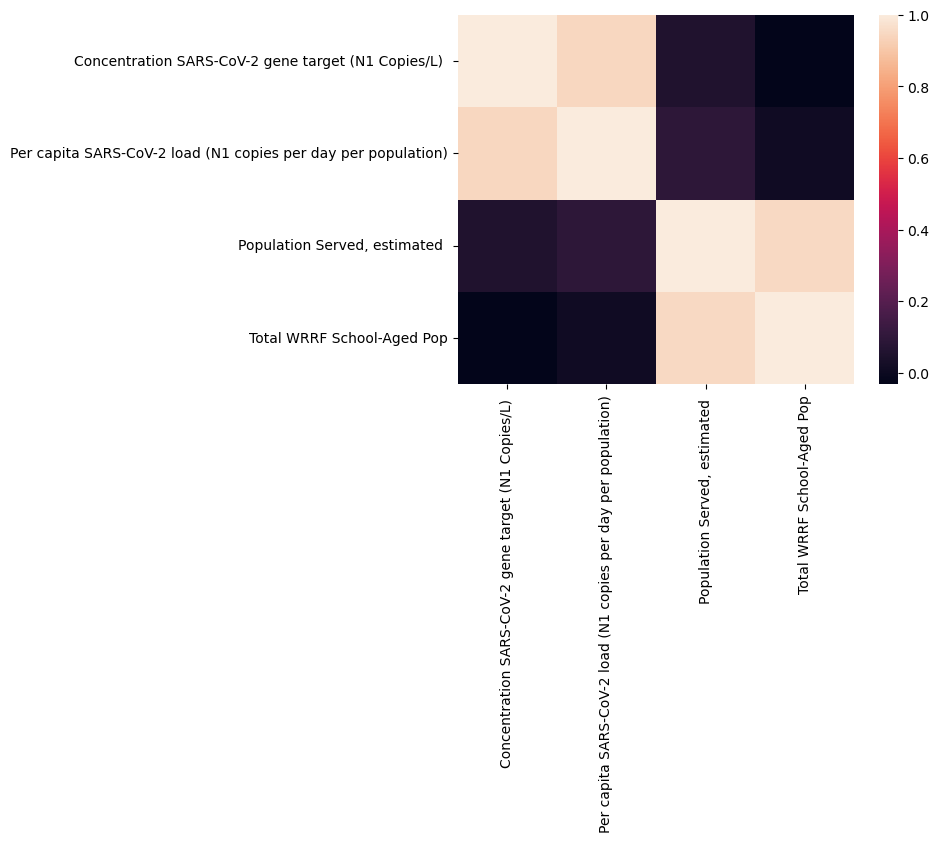

In [142]:
# Let's look at our post-omicron data some more:
merged_df_post_omi.drop
corr = merged_df_post_omi.select_dtypes("number").corr()
sns.heatmap(corr)

In [143]:
# What if we just drop the total population served? Let's check out vif scores. corr seems maybe too high but let's try
# anyway

Index(['Sample Date', 'Test date', 'WRRF Name', 'WRRF Abbreviation',
       'Concentration SARS-CoV-2 gene target (N1 Copies/L) ',
       'Per capita SARS-CoV-2 load (N1 copies per day per population)',
       'Annotation', 'Population Served, estimated ', 'Test Date',
       'Total WRRF School-Aged Pop'],
      dtype='object')

In [144]:
# Have to rename 'Total WRRF School-Aged Pop' due to conflict with hyphen

merged_df_post_omi.rename({'Total WRRF School-Aged Pop': 'Total WRRF Schoolaged Pop'},axis=1, inplace=True)

merged_df_post_omi.columns = merged_df_post_omi.columns.str.replace(' ', '_', regex=True).str.replace('-', '_', regex=True).str.replace(',', '', regex=True).str.replace('(', '', regex=True).str.replace(')', '', regex=True).str.replace('/', '', regex=True).str.strip()



In [145]:
y, X = dmatrices('Concentration_SARS_CoV_2_gene_target_N1_CopiesL_ ~ Population_Served_estimated_+Total_WRRF_Schoolaged_Pop', data=merged_df_post_omi, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif


,VIF,variable
0,4.176417,Intercept
1,10.358255,Population_Served_estimated_
2,10.358255,Total_WRRF_Schoolaged_Pop


In [146]:
# Alright, very high VIFs, bud still don't want to remote this data. Would be nice to break it down by age groups within
# school-age children as we originally sourced in the other csv file.

# Feature Engineering for Post-Omicron

In [147]:
# Have to reset index to date to match it against holidays
merged_df_post_omi.set_index('Sample_Date', inplace=True)

In [148]:
# Holidays: Federal US Holidays


us_holidays = holidays.UnitedStates(years=[2021, 2022, 2023])

def is_holiday(date):
    return date in us_holidays




In [149]:
# Holidays: Jewish Holidays 

# Major Jewish Holidays, 2021
us_holidays[datetime.date(2021, 11, 28)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 29)] = 'Chanukah'
us_holidays[datetime.date(2021, 11, 30)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 1)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 2)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 3)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 4)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 5)] = 'Chanukah'
us_holidays[datetime.date(2021, 12, 6)] = 'Chanukah'

# Major Jewish Holidays, 2022
us_holidays[datetime.date(2022, 3, 16)] = 'Purim'
us_holidays[datetime.date(2022, 3, 17)] = 'Purim'
us_holidays[datetime.date(2022, 4, 15)] = 'Passover'
us_holidays[datetime.date(2022, 4, 16)] = 'Passover'
us_holidays[datetime.date(2022, 4, 17)] = 'Passover'
us_holidays[datetime.date(2022, 4, 18)] = 'Passover'
us_holidays[datetime.date(2022, 4, 19)] = 'Passover'
us_holidays[datetime.date(2022, 4, 20)] = 'Passover'
us_holidays[datetime.date(2022, 4, 21)] = 'Passover'
us_holidays[datetime.date(2022, 4, 22)] = 'Passover'
us_holidays[datetime.date(2022, 4, 23)] = 'Passover'
us_holidays[datetime.date(2022, 6, 4)] = 'Shauvot'
us_holidays[datetime.date(2022, 6, 5)] = 'Shauvot'
us_holidays[datetime.date(2022, 6, 6)] = 'Shauvot'
us_holidays[datetime.date(2022, 9, 25)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 9, 26)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 9, 27)] = 'Rosh Hashanah'
us_holidays[datetime.date(2022, 10, 4)] = 'Yom Kippur'
us_holidays[datetime.date(2022, 10, 5)] = 'Yom Kippur'
us_holidays[datetime.date(2022, 10, 9)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 10)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 11)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 12)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 13)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 14)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 15)] = 'Sukkot'
us_holidays[datetime.date(2022, 10, 16)] = 'Sukkot'
us_holidays[datetime.date(2022, 12, 18)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 19)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 20)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 21)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 22)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 23)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 24)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 25)] = 'Chanukah'
us_holidays[datetime.date(2022, 12, 26)] = 'Chanukah'


# Major Jewish holidays, 2023
us_holidays[datetime.date(2023, 3, 6)] = 'Purim'
us_holidays[datetime.date(2023, 3, 7)] = 'Purim'
us_holidays[datetime.date(2023, 4, 5)] = 'Passover'
us_holidays[datetime.date(2023, 4, 6)] = 'Passover'
us_holidays[datetime.date(2023, 4, 7)] = 'Passover'
us_holidays[datetime.date(2023, 4, 8)] = 'Passover'
us_holidays[datetime.date(2023, 4, 9)] = 'Passover'
us_holidays[datetime.date(2023, 4, 10)] = 'Passover'
us_holidays[datetime.date(2023, 4, 11)] = 'Passover'
us_holidays[datetime.date(2023, 4, 12)] = 'Passover'
us_holidays[datetime.date(2023, 4, 13)] = 'Passover'


In [150]:
# unsure how 1970 got in there, but our filter will filter out anything not in our date range
merged_df_post_omi['Holiday'] = merged_df_post_omi.index.map(is_holiday).astype(int)


In [151]:
merged_df_post_omi['Holiday'].value_counts()

0    228
1     18
Name: Holiday, dtype: int64

In [152]:
# Let's add seasons again. Keeping the index for now

def get_season(date):
    if date.strftime('%Y-%m-%d') >= '2021-03-20' and date.strftime('%Y-%m-%d') <= '2021-06-19':
        return 'Spring 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-06-20' and date.strftime('%Y-%m-%d') <= '2021-09-21':
        return 'Summer 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-09-22' and date.strftime('%Y-%m-%d') <= '2021-12-20':
        return 'Fall 2021'
    elif date.strftime('%Y-%m-%d') >= '2021-12-21' and date.strftime('%Y-%m-%d') <= '2022-03-19':
        return 'Winter 2021'
    elif date.strftime('%Y-%m-%d') >= '2022-03-20' and date.strftime('%Y-%m-%d') <= '2022-06-19':
        return 'Spring 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-06-20' and date.strftime('%Y-%m-%d') <= '2022-09-21':
        return 'Summer 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-09-22' and date.strftime('%Y-%m-%d') <= '2022-12-20':
        return 'Fall 2022'
    elif date.strftime('%Y-%m-%d') >= '2022-12-21' and date.strftime('%Y-%m-%d') <= '2023-03-19':
        return 'Winter 2022'
    elif date.strftime('%Y-%m-%d') >= '2023-03-20' and date.strftime('%Y-%m-%d') <= '2023-06-19':
        return 'Spring 2023'
    elif date.strftime('%Y-%m-%d') >= '2023-06-20' and date.strftime('%Y-%m-%d') <= '2023-09-21':
        return 'Summer 2023'
    else: 
        return 'Fall 2023'


merged_df_post_omi['Season'] = merged_df_post_omi.index.map(get_season)

merged_df_post_omi.sample(5)

,Test_date,WRRF_Name,WRRF_Abbreviation,Concentration_SARS_CoV_2_gene_target_N1_CopiesL_,Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population,Annotation,Population_Served_estimated_,Test_Date,Total_WRRF_Schoolaged_Pop,Holiday,Season
Sample_Date,,,,,,,,,,,
2022-05-17,05/18/2022,Red Hook,RH,17144.08,7240000.00,Lower PCR efficiency: 79%,224029,2022-05-17,33636.0,0,Spring 2022
2022-12-11,12/12/2022,Red Hook,RH,18839.00,10800000.00,low standard curve efficiency,224029,2022-12-11,33636.0,0,Fall 2022
2022-05-22,05/23/2022,Coney Island,CI,6928.00,3650000.00,Lower PCR efficiency: 78%,682342,2022-05-22,117865.0,0,Spring 2022
2021-12-26,12/27/2021,Port Richmond,PR,162949.00,60000829.31,This sample was analyzed in duplicate. The hig...,226167,2021-12-26,46435.0,0,Winter 2021
2022-02-15,02/16/2022,Wards Island,WI,1381.00,727000.00,This sample was analyzed in duplicate. The hig...,1201485,2022-02-15,240219.0,0,Winter 2021


In [153]:
# Now that we've got our seasons and holidays, let's reset the index and make "Sample Date" a column.

merged_df_post_omi.reset_index(inplace=True)


In [154]:
# Only thing left to add is school events, which in this case would just be normal school schedules and which
# would map closely to seasons. Let's leave that category out.

# Let's rename columns before saving our post-omicron data.  

merged_df_post_omi.rename(columns={
    'Concentration_SARS_CoV_2_gene_target_N1_CopiesL_': 'Gene Copies (N1/L)',
    'Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population': 'Per Capita Gene Copies',
    'Population_Served_estimated_': 'Population Served, estimated',
    'Total_WRRF_Schoolaged_Pop': 'School-Aged Population'}, inplace=True)

# merged_df_post_omi.to_csv('data/post_omi.csv', index=False)


In [155]:
# Post-Omicron Modelling with More Engineered Features

post_omi_df = pd.read_csv('data/post_omi.csv')
post_omi_df.sample(5)
post_omi_df['Sample_Date'] = pd.to_datetime(post_omi_df['Sample_Date'])

In [159]:
date_cols = []
cat_cols = []  
num_cols = []   


num_cols = []   

for i in post_omi_df.columns:
    if i == 'Gene Copies (N1/L)' or i == 'Holiday':
        pass 
    elif post_omi_df[i].dtype == 'object':
        cat_cols.append(i)
    elif post_omi_df[i].dtype == 'datetime64[ns]':
        date_cols.append(i)
    elif post_omi_df[i].dtype == 'float64' or merged_df_post_omi[i].dtype == 'int64':
        num_cols.append(i)
    else:
        print("error")
        
print(date_cols)
print(cat_cols)
print(num_cols)

['Sample_Date']
['WRRF_Name', 'Season']
['Per Capita Gene Copies', 'Population Served, estimated', 'School-Aged Population']


In [162]:
y = post_omi_df ['Gene Copies (N1/L)']

X = post_omi_df.drop('Gene Copies (N1/L)', axis=1)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)


In [166]:
cat_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_preprocessor = Pipeline([
    ('selector', ColumnSelector(columns=num_cols)), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_preprocessor, cat_cols),
    ('num', numeric_preprocessor, num_cols),
])

grad_2 = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.1, loss='absolute_error', n_estimators=250, subsample=0.7, random_state=42)


grad_2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',  grad_2)
])

grad_2_pipeline.fit(X_train, y_train)

y_pred = grad_2_pipeline.predict(X_test)

train_score = grad_2_pipeline.score(X_train, y_train)
print(train_score)

test_score = r2_score(y_test, y_pred)
print(test_score)

0.9792571769922698
0.921550615396309


In [ ]:
# Well, adding holidays and seasons gave us a slight boost on our test scores, but clearly there are many
# other factors here that we are not accounting for. We assume the missing variable is the average immunity 
# (antibody duration in particular). Would also like to factor in office re-openings, dropping of mask mandates, etc.